## Importación de paquetes

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from numpy import logical_and as npand
from numpy import logical_or as npor
import matplotlib

from sympy import (symbols, pi, I, E, cos, sin, exp, tan, simplify, expand, factor, collect,
                   apart, cancel, expand_trig, diff, Derivative, Function, integrate, limit,
                   series, Eq, solve, dsolve, Matrix, N, preorder_traversal, Float, solve_linear_system,
                   eye, zeros, lambdify, Symbol,hessian, acos)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import ReferenceFrame, Point, LagrangesMethod
from sympy import legendre_poly

from functools import lru_cache

## Inicializar espacio de trabajo

In [10]:
init_vprinting()

In [11]:
x, t = symbols('x t')

## Probando Polinomios de Legendre

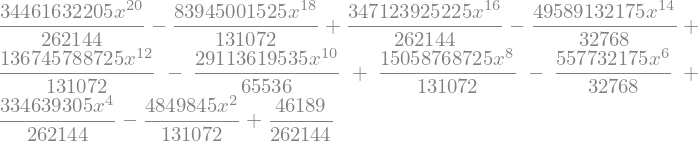

In [12]:
legendre_poly(20)

In [13]:
N = 100
prec = 20
for ii in legendre_poly(N, polys = True).real_roots():
    pass
    #print(ii.evalf(n = prec))

In [14]:
N = 100
prec = 20
for ii in legendre_poly(N, polys = True).diff().real_roots():
    pass
    #print(ii.evalf(n = prec))

## Funciones que generan N collocation points para esquemas LG, LGR y LGL

In [15]:
@lru_cache
def LG(N, precission = 20):
    return [ii.evalf(n = precission) for ii in legendre_poly(N, polys = True).real_roots()]

In [16]:
LG(20,8)

In [17]:
@lru_cache
def LGR(N, precission = 20):
    pol = legendre_poly(N, polys = True) + legendre_poly(N-1, polys = True)
    return [ii.evalf(n = precission) for ii in pol.real_roots()]

In [18]:
LGR(6,8)

In [19]:
@lru_cache
def LGL(N, precission = 20):
    root_list = [ii.evalf(n = precission) for ii in legendre_poly(N-1, polys = True).diff().real_roots()]
    return [-1.,] + root_list + [1.,]

In [20]:
LGL(7,6)

In [21]:
@lru_cache
def LGLm(N, precission = 20):
    return LGL(N+2, precission)[1:-1]

## Bases de Polinomios de Lagrange

In [22]:
#### CREDIT: https://gist.github.com/folkertdev/084c53887c49a6248839 ####

from operator import mul
from functools import reduce, lru_cache
from itertools import chain

# sympy symbols
x = symbols('x')

# convenience functions
product = lambda *args: reduce(mul, *(list(args) + [1]))


# this product may be reusable (when creating many functions on the same domain)
# therefore, cache the result
@lru_cache(16)
def lag_pol(labels, j):
    def gen(labels, j):
        k = len(labels)
        current = labels[j]
        for m in labels:
            if m == current:
                continue
            yield (x - m) / (current - m)
    return expand(product(gen(labels, j)))


def lagrangePolynomial(xs, ys):
    # based on https://en.wikipedia.org/wiki/Lagrange_polynomial#Example_1
    k = len(xs)
    total = 0

    # use tuple, needs to be hashable to cache
    xs = tuple(xs)

    for j, current in enumerate(ys):
        t = current * lag_pol(xs, j)
        total += t

    return total

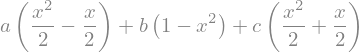

In [23]:
a, b, c = symbols('a b c')
abcpol = lagrangePolynomial([-1, 0, 1], [a, b, c])
abcpol

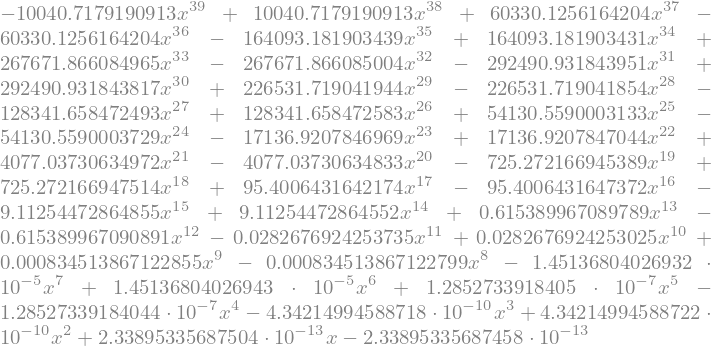

In [24]:
lag_pol(tuple(np.linspace(-1, 1, 40)), 0)

In [25]:
def phi_LGL(N, i):
    return lag_pol(tuple(LGL(N)), i)

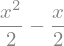

In [26]:
jj = phi_LGL(3,0)
jj

In [27]:
jj.evalf(subs = {x:1})

## Matrices de Derivación LGL

In [28]:
@lru_cache
def matrix_D_1(N, precission):
    taus = LGL(N+1, precission)
    M = zeros(N+1)
    for i in range(N+1):
        func = phi_LGL(N+1, i).diff()
        for k in range(N+1):
            M[k, i] = func.evalf(n = precission, subs = {x:taus[k]})
    return M

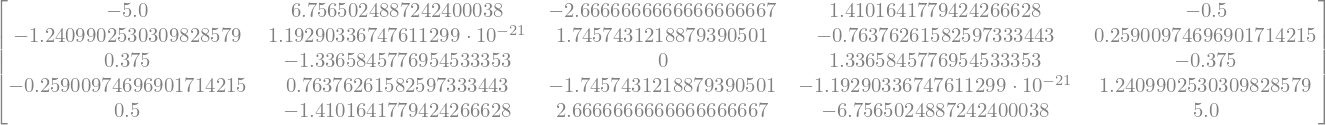

In [29]:
matrix_D_1(4, 20)

In [30]:
@lru_cache
def matrix_D_2(N, precission):
    taus = LGL(N+1, precission)
    M = zeros(N+1)
    LN = legendre_poly(n = N, x=x)
    LN_t = [LN.evalf(n = precission, subs = {x:ii}) for ii in taus]
    for l in range(N+1):
        for k in range(N+1):
            if k != l :
                M[k,l] = LN_t[k]/(LN_t[l] * (taus[k]-taus[l]))
    M[0,0] = -N * (N+1)/4
    M[N,N] = N * (N+1)/4
    return M

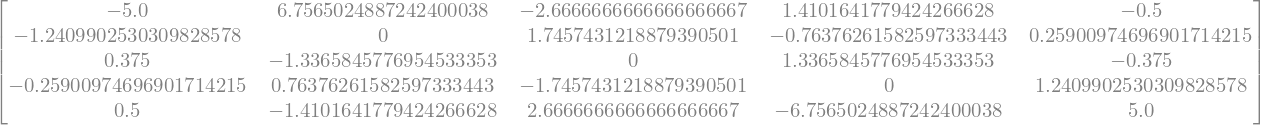

In [31]:
matrix_D_2(4, 20)

In [32]:
def LG_1(N, precission = 20):
    return [-1] + LG(N-1, precission)
def phi_LG_1(N, i):
    return lag_pol(tuple(LG_1(N)), i)
@lru_cache
def matrix_D_LG_1(N, precission):
    taus = LG_1(N+1, precission)
    M = zeros(N+1)
    for i in range(N+1):
        func = phi_LG_1(N+1, i).diff()
        for k in range(N+1):
            M[k, i] = func.evalf(n = precission, subs = {x:taus[k]})
    return M

In [33]:
def LGL_abcpol(N, precission = 20):
    letters = [symbols(ii) for ii in 'abcdefghijklmnopqrsuvw']
    return lagrangePolynomial(LGL(N, precission), letters[:N])

def LG_1_abcpol(N, precission = 20):
    letters = [symbols(ii) for ii in 'abcdefghijklmnopqrsuvw']
    return lagrangePolynomial(LG_1(N, precission), letters[:N])

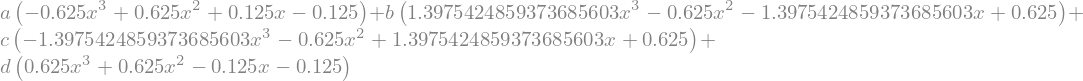

In [34]:
LGL_abcpol(4)

In [35]:
@lru_cache
def LG_1_end_p_fun(N, precission = 20):
    coefs = symbols(f'c_0:{N}')
    pol_lag = lagrangePolynomial(LG_1(N, precission), coefs)
    res = pol_lag.subs(x, 1)
    return lambdify(coefs, res)

@lru_cache
def LG_1_diff_end_p_fun(N, precission = 20):
    coefs = symbols(f'c_0:{N}')
    pol_lag = lagrangePolynomial(LG_1(N, precission), coefs)
    res = pol_lag.diff(x).subs(x, 1)
    return lambdify(coefs, res)

In [36]:
_xx = LG_1_abcpol(3)
_xx.subs(x, 1)

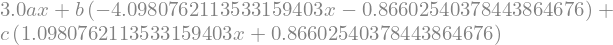

In [37]:
_xx.diff(x)

In [38]:
_xx.diff(x).subs(x,1)

In [39]:
N = 4
letters = [symbols(ii) for ii in 'abcdefghijklmnopqrsuvw']
abcpoldiff = LGL_abcpol(N).diff(x)
for ii in LGL(N):
    print(abcpoldiff.evalf(n = 20, subs = {x:ii}))

-3.0*a + 4.0450849718747371205*b - 1.5450849718747371205*c + 0.5*d
-0.8090169943749474241*a - 1.6940658945086006781e-21*b + 1.1180339887498948482*c - 0.3090169943749474241*d
0.3090169943749474241*a - 1.1180339887498948482*b + 1.6940658945086006781e-21*c + 0.8090169943749474241*d
-0.5*a + 1.5450849718747371205*b - 4.0450849718747371205*c + 3.0*d


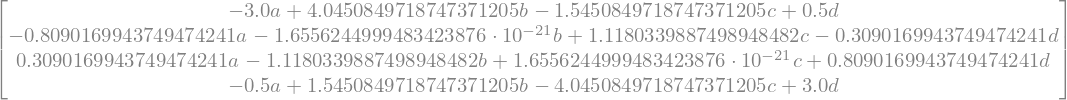

In [40]:
matrix_D_1(N-1,20)@Matrix(letters[:N])

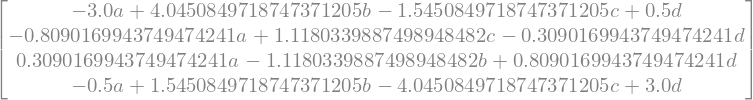

In [41]:
matrix_D_2(N-1,20)@Matrix(letters[:N])

In [42]:
abcpoldiff2 = abcpoldiff.diff(x)
for ii in LGL(N):
    print(abcpoldiff2.evalf(n = 20, subs = {x:ii}))

5.0*a - 9.6352549156242113615*b + 7.1352549156242113615*c - 2.5*d
2.9270509831248422723*a - 5.0*b + 2.5*c - 0.42705098312484227231*d
-0.42705098312484227231*a + 2.5*b - 5.0*c + 2.9270509831248422723*d
-2.5*a + 7.1352549156242113615*b - 9.6352549156242113615*c + 5.0*d


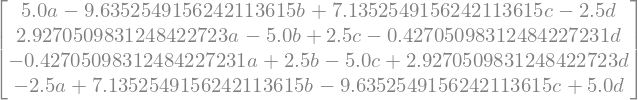

In [43]:
matrix_D_1(N-1,20)@matrix_D_1(N-1,20)@Matrix(letters[:N])

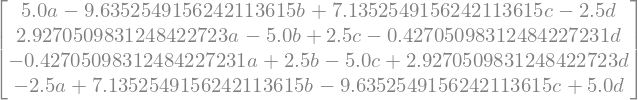

In [44]:
matrix_D_2(N-1,20)@matrix_D_2(N-1,20)@Matrix(letters[:N])

In [45]:
abcpoldiff3 = abcpoldiff2.diff(x)
for ii in LGL(N):
    print(abcpoldiff3.evalf(n = 20, subs = {x:ii}))

-3.75*a + 8.3852549156242113615*b - 8.3852549156242113615*c + 3.75*d
-3.75*a + 8.3852549156242113615*b - 8.3852549156242113615*c + 3.75*d
-3.75*a + 8.3852549156242113615*b - 8.3852549156242113615*c + 3.75*d
-3.75*a + 8.3852549156242113615*b - 8.3852549156242113615*c + 3.75*d


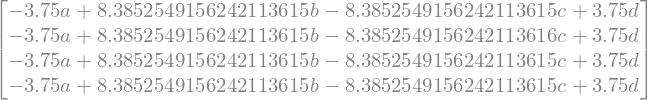

In [46]:
matrix_D_1(N-1,20)@matrix_D_1(N-1,20)@matrix_D_1(N-1,20)@Matrix(letters[:N])

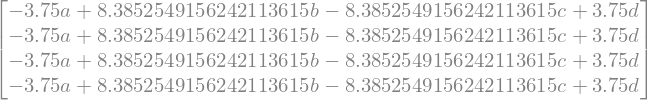

In [47]:
matrix_D_2(N-1,20)@matrix_D_2(N-1,20)@matrix_D_2(N-1,20)@Matrix(letters[:N])

In [48]:
abcpoldiff4 = abcpoldiff3.diff(x)
for ii in LGL(N):
    print(abcpoldiff4.evalf(n = 20, subs = {x:ii}))

0
0
0
0


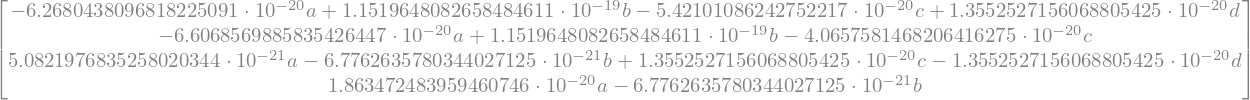

In [49]:
matrix_D_1(N-1,20)@matrix_D_1(N-1,20)@matrix_D_1(N-1,20)@matrix_D_1(N-1,20)@Matrix(letters[:N])

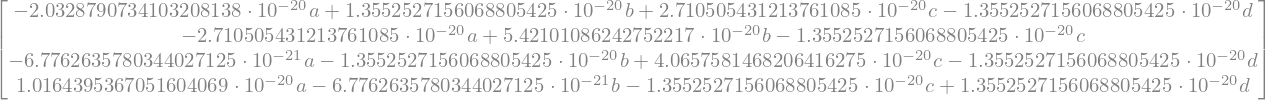

In [50]:
matrix_D_2(N-1,20)@matrix_D_2(N-1,20)@matrix_D_2(N-1,20)@matrix_D_2(N-1,20)@Matrix(letters[:N])

## Problema de ejemplo: bloque que desliza

$$\dot x_1 = x_2$$
$$\dot x_2 = u $$

Minimizar $t_f$ sujeto a:

$t_0 = 0\$

$x_2(0) = x_2(t_f) = 0$

$x_1(0) = 0\ ,\ x_1(t_f) = 1$

$ u_{min} < u(t) < u_{max}$

In [51]:
def error_transcr(pol_q, pol_v, pol_u, t0, t1):
    pol_q_dot = pol_q.diff(x)
    pol_v_dot = pol_v.diff(x)
    
    err_q_dot_pol = (pol_q_dot-pol_v)**2
    err_v_dot_pol = (pol_v_dot-pol_u)**2
    
    return err_q_dot_pol.integrate([x, t0, t1]) + err_v_dot_pol.integrate([x, t0, t1])

In [52]:
import casadi as cas

In [53]:
from optibot.casadi import sympy2casadi

In [54]:
import time

In [55]:
solve_repetitions = 30

#### LGL: función objetivo alternativa

$u(\tau)$ está definida como el polinomio de grado N-1 que pasa por los N valores calculados de $U^N$. Encontrar cómo obtener $\int_{-1}^{1}{u(\tau)^2}$ en función de $U^N$

In [56]:
def obj_f_u_LGL(N, precission = 20):
    coefs = symbols(f'c_0:{N}')
    pol_lag = lagrangePolynomial(LGL(N, precission), coefs)
    res = integrate(pol_lag ** 2, [x, -1, 1])
    return lambdify(coefs, res)

def obj_f_u_LG2(N, precission = 20):
    coefs = symbols(f'c_0:{N}')
    pol_lag = lagrangePolynomial(LG(N, precission), coefs)
    res = integrate(pol_lag ** 2, [x, -1, 1])
    return lambdify(coefs, res)

In [57]:
_xx = cas.SX.sym('x', 5)
_xx

SX([x_0, x_1, x_2, x_3, x_4])

In [58]:
cas.vertsplit(_xx)

[SX(x_0), SX(x_1), SX(x_2), SX(x_3), SX(x_4)]

In [59]:
@lru_cache
def LG_1_end_p_fun_cas(N, precission = 20):
    coefs = symbols(f'c_0:{N}')
    pol_lag = lagrangePolynomial(LG_1(N, precission), coefs)
    res = pol_lag.subs(x, 1)
    x_cas = cas.SX.sym('x', N)
    res_cas = sympy2casadi(res, coefs, cas.vertsplit(x_cas))
    return cas.Function(
    "dynamics_x",
    [x_cas],
    [res_cas])

@lru_cache
def LG_1_diff_end_p_fun_cas(N, precission = 20):
    coefs = symbols(f'c_0:{N}')
    pol_lag = lagrangePolynomial(LG_1(N, precission), coefs)
    res = pol_lag.diff(x).subs(x, 1)
    x_cas = cas.SX.sym('x', N)
    res_cas = sympy2casadi(res, coefs, cas.vertsplit(x_cas))
    return cas.Function(
    "dynamics_x",
    [x_cas],
    [res_cas])

In [63]:
LG_1_end_p_fun(3)(1,2,3)

### Formulación clásica $\dot x = f(x,u)$

In [64]:
x_sym = cas.SX.sym('x', 2)
x_dot_sym = cas.SX.sym('x_dot', 2)
u_sym = cas.SX.sym('u',1)

dynam_f_x = cas.Function(
    "dynamics_x",
    [x_sym, x_dot_sym, u_sym],
    [x_dot_sym[1]-u_sym]
)

In [65]:
N = 7
opti = cas.Opti()
opti.solver('ipopt')

In [66]:
x_opti = opti.variable(N, 2)
u_opti = opti.variable(N)
tau_arr = LGL(N, 20)
t_f = opti.variable(1)
t_0 = 0
u_lim = opti.parameter(1)

In [67]:
D_mat = sympy2casadi(matrix_D_2(N-1,20), [], [])
x_dot_opti = (2/t_f - t_0) * D_mat@x_opti

#cost = cas.sum1(u_opti**2)
#f_obj = obj_f_u_LGL(N)
#cost = f_obj(*cas.vertsplit(u_opti))
cost = t_f
opti.minimize(cost)

In [68]:
opti.subject_to(x_opti[0,:].T == [0., 0.])
opti.subject_to(x_opti[-1,:].T == [1. ,0.])
opti.subject_to(t_f > 0)

for ii in range(N):
    opti.subject_to(dynam_f_x(x_opti[ii,:], x_dot_opti[ii,:], u_opti[ii,:])==0)
    opti.subject_to(x_opti[ii,1] == x_dot_opti[ii,0])
    opti.subject_to(u_opti[ii] <= u_lim[0])
    opti.subject_to(-u_lim[0] <= u_opti[ii])

opti.set_value(u_lim, 1.)
opti.set_initial(t_f, 1.)

In [69]:
cput0 = time.time()
for ii in range(solve_repetitions):
    sol = opti.solve()
cput1 = time.time()
cpudt_LGL = (cput1-cput0)/solve_repetitions


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      130
Number of nonzeros in inequality constraint Jacobian.:       15
Number of nonzeros in Lagrangian Hessian.............:       15

Total number of variables............................:       22
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equal

   8  2.0843681e+00 2.45e-06 2.22e-06  -5.7 4.80e-03    -  1.00e+00 1.00e+00h  1
   9  2.0843603e+00 4.94e-11 1.97e-10  -8.6 1.51e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   2.0843602859793426e+00    2.0843602859793426e+00
Dual infeasibility......:   1.9652393120140869e-10    1.9652393120140869e-10
Constraint violation....:   4.9422577141911006e-11    4.9422577141911006e-11
Complementarity.........:   2.6041107330455625e-09    2.6041107330455625e-09
Overall NLP error.......:   2.6041107330455625e-09    2.6041107330455625e-09


Number of objective function evaluations             = 17
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 17
Number of inequality constraint evaluations          = 17
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluations = 10
Nu

In [70]:
xx_sol_LGL = sol.value(x_opti)
uu_sol_LGL = sol.value(u_opti)
t_f_LGL = sol.value(t_f)

t_arr_LGL = t_0 + (1 + np.array(tau_arr))*(t_f_LGL - t_0)/2

q_pol_LGL = lagrangePolynomial(t_arr_LGL, xx_sol_LGL[:,0])
v_pol_LGL = lagrangePolynomial(t_arr_LGL, xx_sol_LGL[:,1])
u_pol_LGL = lagrangePolynomial(t_arr_LGL, uu_sol_LGL[:])

q_interp_f_LGL = lambdify([x,],q_pol_LGL)
v_interp_f_LGL = lambdify([x,],v_pol_LGL)
u_interp_f_LGL = lambdify([x,],u_pol_LGL)

In [71]:
t_arr_LGL

array([0.0, 0.17693728405263238630, 0.55355524036982750399,
       1.04218014298967, 1.5308050456095151378, 1.9074230019267102555,
       2.0843602859793426], dtype=object)

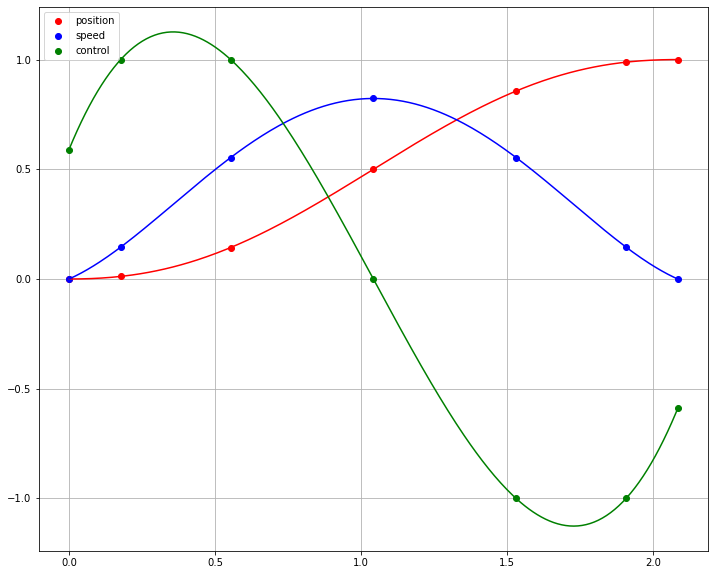

In [72]:
plt.figure(figsize=[12,10])
plt.plot(t_arr_LGL, xx_sol_LGL[:,0], 'ro', label = 'position')
plt.plot(t_arr_LGL, xx_sol_LGL[:,1], 'bo', label = 'speed')
plt.plot(t_arr_LGL, uu_sol_LGL[:], 'go', label = 'control')
N_interp = 300
t_int_arr_LGL = np.linspace(t_0, t_f_LGL, N_interp)
plt.plot(t_int_arr_LGL, q_interp_f_LGL(t_int_arr_LGL), 'r')
plt.plot(t_int_arr_LGL, v_interp_f_LGL(t_int_arr_LGL), 'b')
plt.plot(t_int_arr_LGL, u_interp_f_LGL(t_int_arr_LGL), 'g')
plt.grid()
plt.legend()

In [73]:
#u_sq_LGL = u_interp_f_LGL(t_int_arr)**2
#quality_LGL = np.trapz(u_sq_LGL, t_int_arr)
quality_LGL = t_f_LGL
quality_LGL

In [74]:
cpudt_LGL*1000

In [75]:
trun_err_LGL = error_transcr(q_pol_LGL, v_pol_LGL, u_pol_LGL, t_0, t_f_LGL)
trun_err_LGL

### Formulación $D^2$ de Ross, Rea y Fahroo

In [76]:
q_sym = cas.SX.sym('q', 1)
q_dot_sym = cas.SX.sym('q_dot', 1)
q_dot_dot_sym = cas.SX.sym('q_dot_dot', 1)
u_sym = cas.SX.sym('u',1)

dynam_f_q = cas.Function(
    "dynamics",
    [q_sym, q_dot_sym, q_dot_dot_sym, u_sym],
    [q_dot_dot_sym-u_sym]
)

In [77]:
N = 9
opti = cas.Opti()
opti.solver('ipopt')

In [78]:
x_opti = opti.variable(N)
u_opti = opti.variable(N)
tau_arr = LGL(N, 20)
t_f = opti.variable(1)
t_0 = 0
u_lim = opti.parameter(1)

In [79]:
D_mat = sympy2casadi(matrix_D_2(N-1,20), [], [])
x_dot_opti = (2/t_f - t_0) * D_mat@x_opti
x_dot_dot_opti = (2/t_f - t_0) * D_mat@x_dot_opti

#cost = cas.sum1(u_opti**2)
#f_obj = obj_f_u_LGL(N)
#cost = f_obj(*cas.vertsplit(u_opti))
cost = t_f
opti.minimize(cost)

In [80]:
opti.subject_to(x_opti[0] == [0.])
opti.subject_to(x_opti[-1] == [1.])
opti.subject_to(x_dot_opti[0] == [0.])
opti.subject_to(x_dot_opti[-1] == [0.])
opti.subject_to(t_f > 0)

for ii in range(N):
    opti.subject_to(dynam_f_q(x_opti[ii], x_dot_opti[ii], x_dot_dot_opti[ii], u_opti[ii,:])==0)
    opti.subject_to(u_opti[ii] <= u_lim[0])
    opti.subject_to(-u_lim[0] <= u_opti[ii])

opti.set_value(u_lim, 1.)
opti.set_initial(t_f, 1.)

In [81]:
cput0 = time.time()
for ii in range(solve_repetitions):
    sol = opti.solve()
cput1 = time.time()
cpudt_D2 = (cput1-cput0)/solve_repetitions

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      121
Number of nonzeros in inequality constraint Jacobian.:       19
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:       19
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       13
Total number of inequality constraints...............:       19
        inequality constraints with only lower bounds:       10
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        9

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  10  2.0746139e+00 2.17e-06 7.25e-06  -5.7 2.93e-03    -  1.00e+00 1.00e+00h  1
  11  2.0746003e+00 1.12e-09 1.80e-09  -8.6 9.05e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   2.0746002704006776e+00    2.0746002704006776e+00
Dual infeasibility......:   1.7987744627134816e-09    1.7987744627134816e-09
Constraint violation....:   1.0083432617749707e-09    1.1150311785002032e-09
Complementarity.........:   2.9612271185655750e-09    2.9612271185655750e-09
Overall NLP error.......:   2.9612271185655750e-09    2.9612271185655750e-09


Number of objective function evaluations             = 23
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 23
Number of inequality constraint evaluations          = 23
Number of equality constraint Jacobian evaluations   = 12
Number of inequality constraint Jacobian evaluations = 12
N

In [82]:
xx_sol_D2 = sol.value(x_opti)
uu_sol_D2 = sol.value(u_opti)
vv_sol_D2 = sol.value(x_dot_opti)
t_f_D2 = sol.value(t_f)

t_arr_D2 = t_0 + (1 + np.array(tau_arr))*(t_f_D2 - t_0)/2

q_pol_D2 = lagrangePolynomial(t_arr_D2, xx_sol_D2[:])
v_pol_D2 = lagrangePolynomial(t_arr_D2, xx_sol_D2[:]).diff(x)
u_pol_D2 = lagrangePolynomial(t_arr_D2, uu_sol_D2[:])

q_interp_f_D2 = lambdify([x,],q_pol_D2)
v_interp_f_D2 = lambdify([x,],v_pol_D2)
u_interp_f_D2 = lambdify([x,],u_pol_D2)

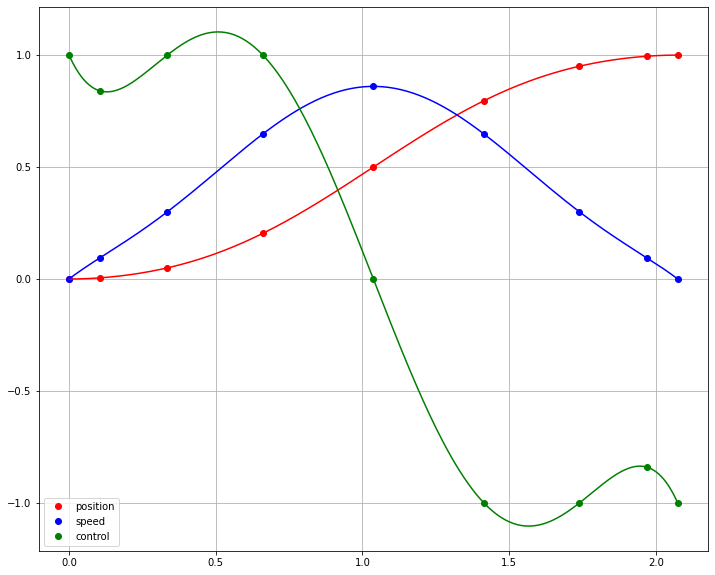

In [83]:
plt.figure(figsize=[12,10])
plt.plot(t_arr_D2, xx_sol_D2[:], 'ro', label = 'position')
plt.plot(t_arr_D2, vv_sol_D2[:], 'bo', label = 'speed')
plt.plot(t_arr_D2, uu_sol_D2[:], 'go', label = 'control')
N_interp = 300
t_int_arr_D2 = np.linspace(t_0, t_f_D2, N_interp)
plt.plot(t_int_arr_D2, q_interp_f_D2(t_int_arr_D2), 'r')
plt.plot(t_int_arr_D2, v_interp_f_D2(t_int_arr_D2), 'b')
plt.plot(t_int_arr_D2, u_interp_f_D2(t_int_arr_D2), 'g')
plt.grid()
plt.legend()

In [84]:
#u_sq_D2 = u_interp_f_D2(t_int_arr)**2
#quality_D2 = np.trapz(u_sq_D2, t_int_arr)
quality_D2 = t_f_D2
quality_D2

In [85]:
cpudt_D2*1000

In [86]:
trun_err_D2 = error_transcr(q_pol_D2, v_pol_D2, u_pol_D2, t_0, t_f_D2)
trun_err_D2

### Formulación nueva LG+2

In [87]:
@lru_cache
def LG2(N, precission = 20):
    return [-1]+LG(N-2, precission)+[1]

In [88]:
def phi_LG2(N, i, precission = 20):
    return lag_pol(tuple(LG2(N, precission)), i)

In [89]:
@lru_cache
def matrix_D_LG2(N, precission):
    taus = LG2(N+1, precission)
    M = zeros(N+1)
    for i in range(N+1):
        func = phi_LG2(N+1, i).diff()
        for k in range(N+1):
            M[k, i] = func.evalf(n = precission, subs = {x:taus[k]})
    return M

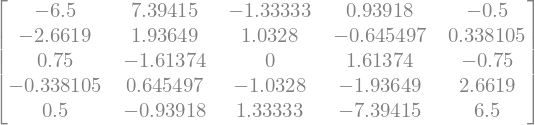

In [90]:
matrix_D_LG2(4,6)

In [91]:
def LG2_abcpol(N, precission = 20):
    letters = [symbols(ii) for ii in 'abcdefghijklmnopqrsuvw']
    return lagrangePolynomial(LG2(N, precission), letters[:N])

In [92]:
N=5
abcpoldiff = LG2_abcpol(N).diff(x)
for ii in LG2(N, 20):
    print(abcpoldiff.evalf(n = 20, subs = {x:ii}))

-6.5*a + 7.3941527885061807376*b - 1.3333333333333333333*c + 0.93918054482715259568*d - 0.5*e
-2.6618950038622250655*a + 1.9364916731037084426*b + 1.0327955589886445027*c - 0.64549722436790281419*d + 0.33810499613777493444*e
0.75*a - 1.6137430609197570355*b + 1.6137430609197570355*d - 0.75*e
-0.33810499613777493445*a + 0.64549722436790281419*b - 1.0327955589886445027*c - 1.9364916731037084426*d + 2.6618950038622250655*e
0.50000000000000000001*a - 0.93918054482715259568*b + 1.3333333333333333333*c - 7.3941527885061807376*d + 6.5*e


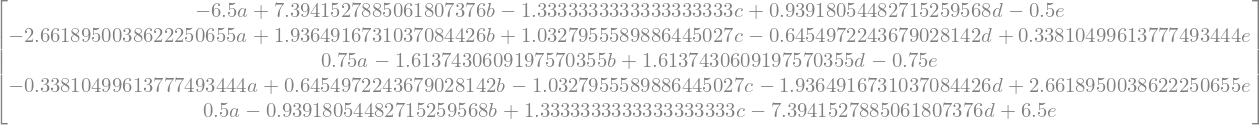

In [93]:
matrix_D_LG2(N-1,20)@Matrix(letters[:N])

Casadi:

In [94]:
q_sym = cas.SX.sym('q', 1)
q_dot_sym = cas.SX.sym('q_dot', 1)
q_dot_dot_sym = cas.SX.sym('q_dot_dot', 1)
u_sym = cas.SX.sym('u',1)

dynam_f = cas.Function(
    "dynamics",
    [q_sym, q_dot_sym, q_dot_dot_sym, u_sym],
    [q_dot_dot_sym-u_sym]
)

In [95]:
N = 7
opti = cas.Opti()
opti.solver('ipopt')

In [96]:
x_opti = opti.variable(N+2)
u_opti = opti.variable(N)
tau_arr_LG2 = LG2(N+2, 20)
t_f = opti.variable(1)
t_0 = 0
u_lim = opti.parameter(1)

In [97]:
D_mat = sympy2casadi(matrix_D_LG2(N+1,20), [], [])
x_dot_opti = (2/t_f - t_0) * D_mat@x_opti
x_dot_dot_opti = (2/t_f - t_0) * D_mat@x_dot_opti

#cost = cas.sum1(u_opti**2)
#f_obj = obj_f_u_LG2(N)
#cost = f_obj(*cas.vertsplit(u_opti))
cost = t_f
opti.minimize(cost)

In [98]:
opti.subject_to(x_opti[0] == [0.])
opti.subject_to(x_opti[-1] == [1.])
opti.subject_to(x_dot_opti[0] == [0.])
opti.subject_to(x_dot_opti[-1] == [0.])
opti.subject_to(t_f > 0)

for ii in range(1, N+1):
    opti.subject_to(dynam_f_q(x_opti[ii], x_dot_opti[ii], x_dot_dot_opti[ii], u_opti[ii-1,:])==0)
    opti.subject_to(u_opti[ii-1] <= u_lim[0])
    opti.subject_to(-u_lim[0] <= u_opti[ii-1])

opti.set_value(u_lim, 1.)
opti.set_initial(t_f, 1.)

In [99]:
cput0 = time.time()
for ii in range(solve_repetitions):
    sol = opti.solve()
cput1 = time.time()
cpudt_LG2 = (cput1-cput0)/solve_repetitions

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       99
Number of nonzeros in inequality constraint Jacobian.:       15
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:       17
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       11
Total number of inequality constraints...............:       15
        inequality constraints with only lower bounds:        8
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        7

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   7  2.0422375e+00 7.72e-03 1.25e-01  -3.8 1.02e-01    -  9.55e-01 1.00e+00f  1
   8  2.0312231e+00 1.34e-04 2.01e-04  -3.8 2.27e-02    -  1.00e+00 1.00e+00h  1
   9  2.0301412e+00 1.20e-06 1.65e-05  -5.7 1.52e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.0301287e+00 1.64e-10 1.96e-09  -8.6 1.75e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   2.0301286842308768e+00    2.0301286842308768e+00
Dual infeasibility......:   1.9573676013351360e-09    1.9573676013351360e-09
Constraint violation....:   1.2044798491928077e-10    1.6359680277133748e-10
Complementarity.........:   2.5589779637129513e-09    2.5589779637129513e-09
Overall NLP error.......:   2.5589779637129513e-09    2.5589779637129513e-09


Number of objective function evaluations             = 21
Number of objective gradient evaluations        

In [100]:
xx_sol_LG2 = sol.value(x_opti)
uu_sol_LG2 = sol.value(u_opti)
vv_sol_LG2 = sol.value(x_dot_opti)
t_f_LG2 = sol.value(t_f)

t_arr_LG2 = t_0 + (1 + np.array(tau_arr_LG2))*(t_f_D2 - t_0)/2
coll_p_t = t_0 + (1 + np.array(LG(N)))*(t_f_LG2 - t_0)/2

q_pol_LG2 = lagrangePolynomial(t_arr_LG2, xx_sol_LG2[:])
v_pol_LG2 = lagrangePolynomial(t_arr_LG2, xx_sol_LG2[:]).diff(x)
u_pol_LG2 = lagrangePolynomial(coll_p_t, uu_sol_LG2[:])

q_interp_f_LG2 = lambdify([x,],q_pol_LG2)
v_interp_f_LG2 = lambdify([x,],v_pol_LG2)
u_interp_f_LG2 = lambdify([x,],u_pol_LG2)

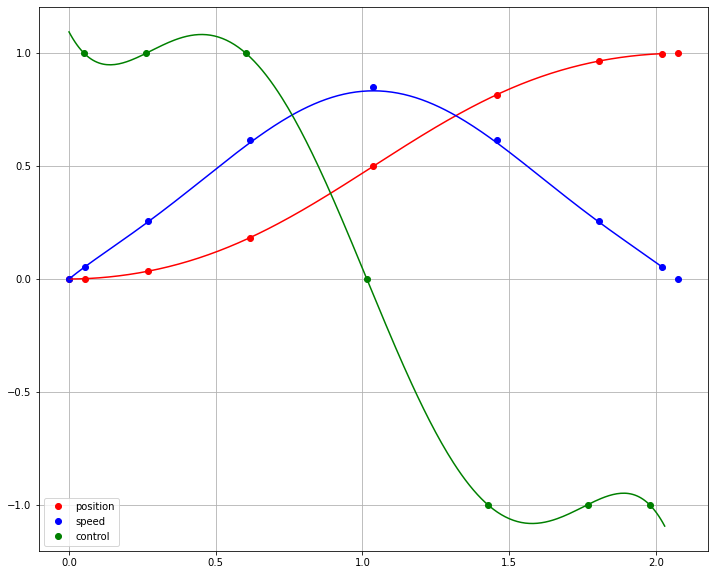

In [101]:
plt.figure(figsize=[12,10])
plt.plot(t_arr_LG2, xx_sol_LG2[:], 'ro', label = 'position')
plt.plot(t_arr_LG2, vv_sol_LG2[:], 'bo', label = 'speed')
plt.plot(coll_p_t, uu_sol_LG2[:], 'go', label = 'control')
N_interp = 300
t_int_arr_LG2 = np.linspace(t_0, t_f_LG2, N_interp)
plt.plot(t_int_arr_LG2, q_interp_f_LG2(t_int_arr_LG2), 'r')
plt.plot(t_int_arr_LG2, v_interp_f_LG2(t_int_arr_LG2), 'b')
plt.plot(t_int_arr_LG2, u_interp_f_LG2(t_int_arr_LG2), 'g')
plt.grid()
plt.legend()

In [102]:
#u_sq_LG2 = u_interp_f_LG2(t_int_arr)**2
#quality_LG2 = np.trapz(u_sq_LG2, t_int_arr)
quality_LG2 = t_f_LG2
quality_LG2

In [103]:
cpudt_LG2*1000

In [104]:
trun_err_LG2 = error_transcr(q_pol_LG2, v_pol_LG2, u_pol_LG2, t_0, t_f_LG2)
trun_err_LG2

## COMPARACIÓN DE RESULTADOS

In [105]:
from IPython.display import Markdown as md
md(f'''| | Usual LGL | $D^2$ | Nuevo LG2 |
| --- | --- | --- | --- |
| Coste a optimizar ($t_f$) | {round(quality_LGL,5)} | {round(quality_D2,5)} | {round(quality_LG2,5)} |
| Valor medio de $(U^N)^2$ | {round(np.mean(uu_sol_LGL**2),4)} | {round(np.mean(uu_sol_D2**2),4)} | {round(np.mean(uu_sol_LG2**2),4)} |
| CPU time (ms) | {round(cpudt_LGL*1000,4)} | {round(cpudt_D2*1000,4)} | {round(cpudt_LG2*1000,4)} |
| Integrated Truncation Error | {"{:.2e}".format(trun_err_LGL)} | {trun_err_D2} | {trun_err_LG2} |''')

| | Usual LGL | $D^2$ | Nuevo LG2 |
| --- | --- | --- | --- |
| Coste a optimizar ($t_f$) | 2.08436 | 2.0746 | 2.03013 |
| Valor medio de $(U^N)^2$ | 0.6709 | 0.8238 | 0.8571 |
| CPU time (ms) | 11.984 | 12.1508 | 11.634 |
| Integrated Truncation Error | 2.70e-21 | 1.0102621981144303333E-18 | 0.0063315889624835169459 |

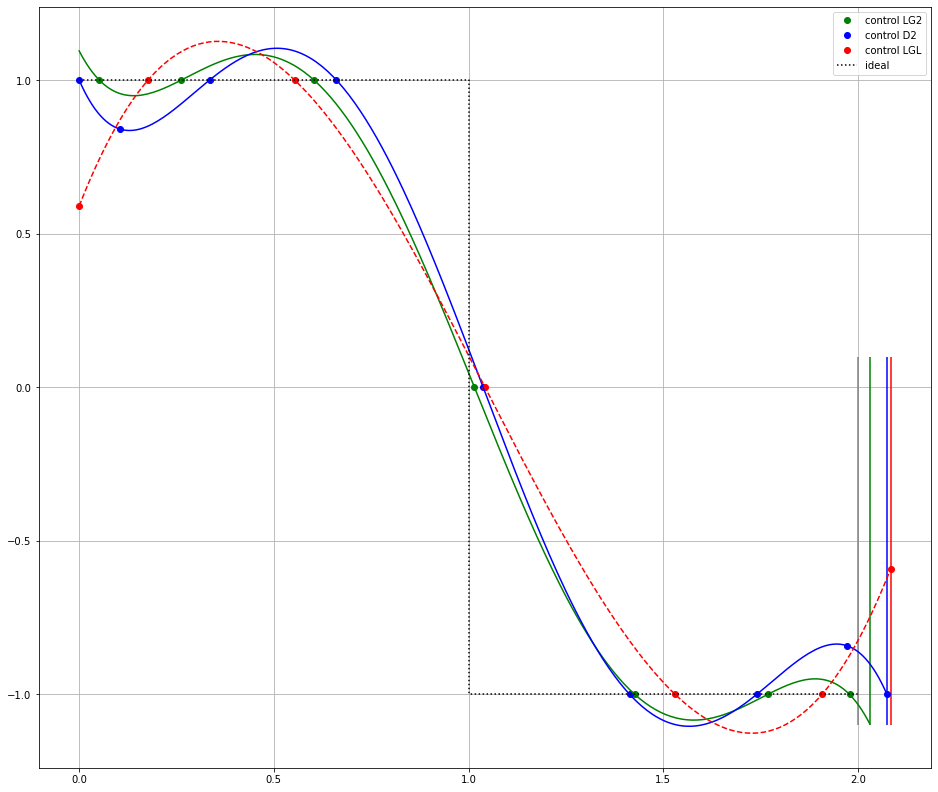

In [106]:
plt.figure(figsize=[16,14])

plt.plot(coll_p_t, uu_sol_LG2[:], 'go', label = 'control LG2')
plt.plot(t_arr_D2, uu_sol_D2[:], 'bo', label = 'control D2')
plt.plot(t_arr_LGL, uu_sol_LGL[:], 'ro', label = 'control LGL')

plt.plot(t_int_arr_LG2, u_interp_f_LG2(t_int_arr_LG2), 'g')
plt.plot(t_int_arr_D2, u_interp_f_D2(t_int_arr_D2), 'b')
plt.plot(t_int_arr_LGL, u_interp_f_LGL(t_int_arr_LGL), 'r--')
plt.plot([0,1,1,2], [1,1,-1,-1], 'k:', label = 'ideal')
plt.vlines([2, t_f_LGL, t_f_D2, t_f_LG2], -1.1, 0.1, colors=['gray', 'r', 'b', 'g'] )
plt.grid()
plt.legend()

## Benchmarking de N y Convergencia

In [107]:
def opt_LGL_bloq_u(N):
    u_arr = np.zeros(N)
    u_arr[:N//2] = 1
    u_arr[-(N//2):] = -1
    return u_arr

In [ ]:

def error_transcr_bloq(qq, vv, uu, scheme, t0, t1):
    N = len(qq)
    if scheme == 'LG2':
        tau = LG2(N, 30)
        pol_u = lagrangePolynomial(LG(N-2, 30), uu)
    elif scheme == 'LG':
        tau = LG_1(N, 30)
        pol_u = lagrangePolynomial(LG(N-1, 30), uu)
    elif scheme == 'LGLm':
        tau = LGL(N,30)
        pol_u = lagrangePolynomial(LGLm(N-2, 30), uu)
    else:
        tau = LGL(N, 30)
        pol_u = lagrangePolynomial(tau, uu)
        
    
    pol_q = lagrangePolynomial(tau, qq)
    pol_v = lagrangePolynomial(tau, vv)
    
    pol_q_dot = 2/(t1 - t0) * pol_q.diff(x)
    pol_v_dot = 2/(t1 - t0) * pol_v.diff(x)
    
    err_q_dot_pol = (pol_q_dot-pol_v)**2
    err_v_dot_pol = (pol_v_dot-pol_u )**2
    
    t_arr = np.linspace(-1, 1, 1000)
    err_q_num = [err_q_dot_pol.evalf(n = 20, subs = {x:ii}) for ii in t_arr]
    err_q_num_int = np.trapz(np.array(err_q_num), t_arr)
    err_v_num = [err_v_dot_pol.evalf(n = 20, subs = {x:ii}) for ii in t_arr]
    err_v_num_int = np.trapz(np.array(err_v_num), t_arr)
    
    return (err_q_num_int + err_v_num_int) * (t1-t0)/2

In [109]:
@lru_cache
def min_t_bloq(col_points = 7, scheme = 'LGL', solve_repetitions = 20, precission = 20):
    opti = cas.Opti()
    opts = {'ipopt.print_level':0, 'print_time':0}
    opti.solver('ipopt', opts)
    
    opt_dict = {
        'LGL': [
            col_points,
            LGL,
            matrix_D_1
        ],
        'D2': [
            col_points,
            LGL,
            matrix_D_1
        ],
        'LG2': [
            col_points+2,
            LG2,
            matrix_D_LG2
        ],
        'LGLm': [
            col_points+2,
            LGLm,
            matrix_D_1
        ],
        'LG': [
            col_points+1,
            LG_1,
            matrix_D_LG_1
        ]
    }
    sch_options = opt_dict[scheme]
    N = sch_options[0]
    
    if scheme == 'LGL' or scheme == 'LG':
        x_opti = opti.variable(N,2)
    else:
        x_opti = opti.variable(N)
    
    u_opti = opti.variable(col_points)
    tau_arr = sch_options[1](N, precission)
    t_f = opti.variable(1)
    t_0 = 0
    u_lim = opti.parameter(1)
    
    D_mat = sympy2casadi(sch_options[2](N-1,precission), [], [])
    x_dot_opti = 2/(t_f - t_0) * D_mat@x_opti
    x_dot_dot_opti = 2/(t_f - t_0) * D_mat@x_dot_opti

    #cost = cas.sum1(u_opti**2)
    #f_obj = obj_f_u_LG2(N)
    #cost = f_obj(*cas.vertsplit(u_opti))
    cost = t_f
    opti.minimize(cost)
         
    opti.subject_to(t_f > 0)   
    if scheme == 'LGL':
        opti.subject_to(x_opti[0,:].T == [0., 0.])
        opti.subject_to(x_opti[-1,:].T == [1. ,0.])
        for ii in range(N):
            opti.subject_to(dynam_f_x(x_opti[ii,:], x_dot_opti[ii,:], u_opti[ii,:])==0)
            opti.subject_to(x_opti[ii,1] == x_dot_opti[ii,0]) 
    if scheme == 'LG':
        endp_f = LG_1_end_p_fun_cas(N, precission)
        opti.subject_to(x_opti[0,:].T == [0., 0.])
        #opti.subject_to(x_opti[-1,:].T == [1. ,0.]) MAL MAL NO USAR NO ES PUNTO FINAL
        opti.subject_to(endp_f(x_opti[:,0]) == 1.)
        opti.subject_to(endp_f(x_opti[:,1]) == 0.)
        #opti.subject_to(x_opti[0,1] == x_dot_opti[0,0])
        for ii in range(1, N):
            opti.subject_to(dynam_f_x(x_opti[ii,:], x_dot_opti[ii,:], u_opti[ii-1,:])==0)
            opti.subject_to(x_opti[ii,1] == x_dot_opti[ii,0])
    elif scheme == 'D2':
        opti.subject_to(x_opti[0] == [0.])
        opti.subject_to(x_opti[-1] == [1.])
        opti.subject_to(x_dot_opti[0] == [0.])
        opti.subject_to(x_dot_opti[-1] == [0.])
        for ii in range(N):
            opti.subject_to(dynam_f_q(x_opti[ii], x_dot_opti[ii], x_dot_dot_opti[ii], u_opti[ii,:])==0)
    elif scheme == 'LG2':
        opti.subject_to(x_opti[0] == [0.])
        opti.subject_to(x_opti[-1] == [1.])
        opti.subject_to(x_dot_opti[0] == [0.])
        opti.subject_to(x_dot_opti[-1] == [0.])
        for ii in range(1, N-1):
            opti.subject_to(dynam_f_q(x_opti[ii], x_dot_opti[ii], x_dot_dot_opti[ii], u_opti[ii-1,:])==0)
    elif scheme == 'LGLm':
        opti.subject_to(x_opti[0] == [0.])
        opti.subject_to(x_opti[-1] == [1.])
        opti.subject_to(x_dot_opti[0] == [0.])
        opti.subject_to(x_dot_opti[-1] == [0.])
        for ii in range(1, N-1):
            opti.subject_to(dynam_f_q(x_opti[ii], x_dot_opti[ii], x_dot_dot_opti[ii], u_opti[ii-1,:])==0)

    
    for ii in range(col_points):
        opti.subject_to(u_opti[ii] <= u_lim[0])
        opti.subject_to(-u_lim[0] <= u_opti[ii])

    opti.set_value(u_lim, 1.)
    opti.set_initial(t_f, 1.)
    
    opti.set_initial(u_opti, list(np.linspace(-1,1,col_points)))
    #opti.set_initial(u_opti, list(opt_LGL_bloq_u(col_points)))
    
    cput0 = time.time()
    for ii in range(solve_repetitions):
        sol = opti.solve()
    cput1 = time.time()
    cpudt = (cput1-cput0)/solve_repetitions
    
    xx_sol = sol.value(x_opti)
    uu_sol = sol.value(u_opti)
    t_f_sol = sol.value(t_f)
    D_mat = np.array(D_mat)

    t_arr = t_0 + (1 + np.array(tau_arr))*(t_f_sol - t_0)/2
    
    if scheme == 'LGL':
        qq_sol = xx_sol[:,0]
        vv_sol = xx_sol[:,1]
        #q_pol = lagrangePolynomial(t_arr, xx_sol[:,0])
        #v_pol = lagrangePolynomial(t_arr, xx_sol[:,1])
        #u_pol = lagrangePolynomial(t_arr, uu_sol[:])
    if scheme == 'LG':
        qq_sol = xx_sol[:,0]
        vv_sol = xx_sol[:,1]
        #q_pol = lagrangePolynomial(t_arr, xx_sol[:,0])
        #v_pol = lagrangePolynomial(t_arr, xx_sol[:,1])
        #u_pol = lagrangePolynomial(t_arr, uu_sol[:])
    elif scheme == 'D2':
        qq_sol = xx_sol
        vv_sol = 2/(t_f_sol - t_0) * D_mat@qq_sol
        #q_pol = lagrangePolynomial(t_arr, xx_sol[:])
        #v_pol = lagrangePolynomial(t_arr, xx_sol[:]).diff(x)
        #u_pol = lagrangePolynomial(t_arr, uu_sol[:])
    elif scheme == 'LG2':
        qq_sol = xx_sol
        vv_sol = 2/(t_f_sol - t_0) * D_mat@qq_sol
        #coll_p_t = t_0 + (1 + np.array(LG(col_points)))*(t_f_sol - t_0)/2
        #q_pol = lagrangePolynomial(t_arr, xx_sol[:])
        #v_pol = lagrangePolynomial(t_arr, xx_sol[:]).diff(x)
        #u_pol = lagrangePolynomial(coll_p_t, uu_sol[:])
    elif scheme == 'LGLm':
        qq_sol = xx_sol
        vv_sol = 2/(t_f_sol - t_0) * D_mat@qq_sol
        #coll_p_t = t_0 + (1 + np.array(LGLm(col_points)))*(t_f_sol - t_0)/2
        #q_pol = lagrangePolynomial(t_arr, xx_sol[:])
        #v_pol = lagrangePolynomial(t_arr, xx_sol[:]).diff(x)
        #u_pol = lagrangePolynomial(coll_p_t, uu_sol[:])
        
    #trun_err = error_transcr(q_pol, v_pol, u_pol, t_0, t_f_sol)
    trun_err = error_transcr_bloq(qq_sol, vv_sol, uu_sol, scheme, t_0, t_f_sol)
    
    return t_f_sol, cpudt, trun_err, uu_sol, qq_sol, vv_sol

In [110]:
if not 'results_bloq' in globals():
    results_bloq = {}
test_N = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,30,35,40,45,50]
for scheme in ['LG','LGL', 'D2', 'LG2', 'LGLm']:
    print(f'\n\t\t NUEVO ESQUEMA: {scheme}\n')
    t_f_list = []
    cpudt_list = []
    tran_err_list = []
    uu_sol_list = []
    qq_sol_list = []
    vv_sol_list = []
    for N_col in test_N:
        print(f' Problema: {N_col} Collocation Points')
        time.sleep(0.01)
        t_f_sol, cpudt, tran_err, uu_sol, qq_sol, vv_sol = min_t_bloq(col_points = N_col,
                                              scheme = scheme,
                                              solve_repetitions = 10,
                                              precission = 20)
        t_f_list.append(t_f_sol)
        cpudt_list.append(cpudt)
        tran_err_list.append(tran_err)
        uu_sol_list.append(uu_sol)
        qq_sol_list.append(qq_sol)
        vv_sol_list.append(vv_sol)
    results_bloq[scheme] = {
        't_f': t_f_list ,
        'cpu_t' : cpudt_list ,
        'tr_err' : tran_err_list,
        'u' : uu_sol_list,
        'N' : test_N,
        'q' : qq_sol_list,
        'v' : vv_sol_list}


		 NUEVO ESQUEMA: LG

 Problema: 4 Collocation Points
 Problema: 5 Collocation Points
 Problema: 6 Collocation Points
 Problema: 7 Collocation Points
 Problema: 8 Collocation Points
 Problema: 9 Collocation Points
 Problema: 10 Collocation Points
 Problema: 11 Collocation Points
 Problema: 12 Collocation Points
 Problema: 13 Collocation Points
 Problema: 14 Collocation Points
 Problema: 15 Collocation Points
 Problema: 16 Collocation Points
 Problema: 17 Collocation Points
 Problema: 18 Collocation Points
 Problema: 19 Collocation Points
 Problema: 20 Collocation Points
 Problema: 21 Collocation Points
 Problema: 22 Collocation Points
 Problema: 23 Collocation Points
 Problema: 24 Collocation Points
 Problema: 25 Collocation Points
 Problema: 30 Collocation Points
 Problema: 35 Collocation Points
 Problema: 40 Collocation Points
 Problema: 45 Collocation Points
 Problema: 50 Collocation Points

		 NUEVO ESQUEMA: LGL

 Problema: 4 Collocation Points
 Problema: 5 Collocation Points
 Pro

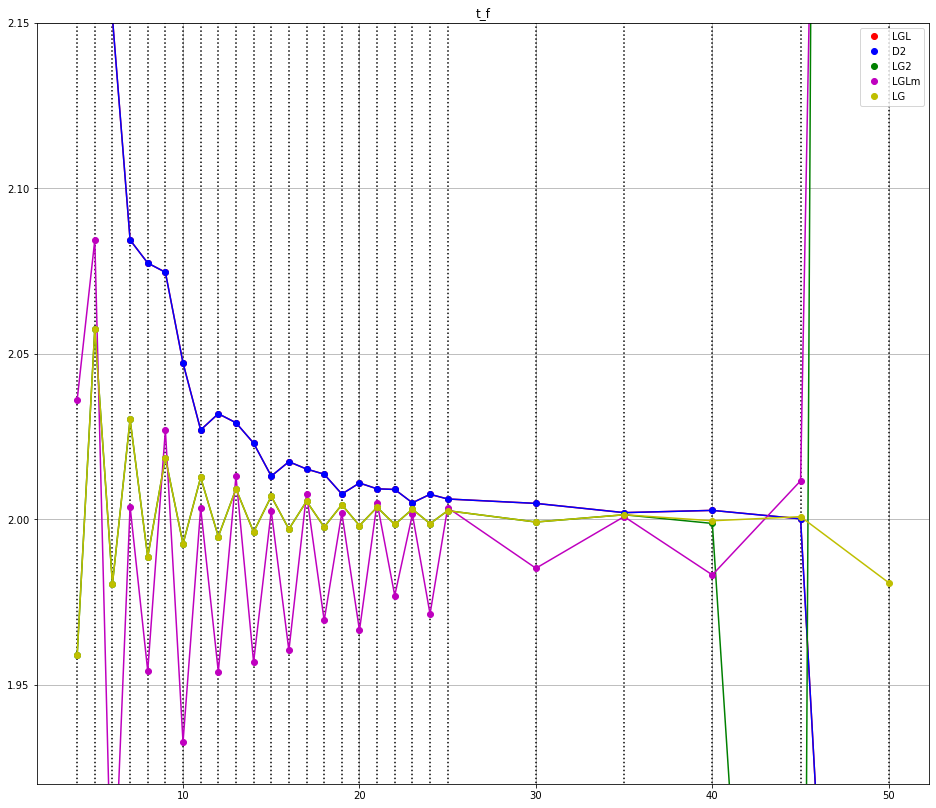

In [111]:
plt.figure(figsize=[16,14])

schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
plt.title('t_f')
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['t_f'], color + 'o', label = scheme)
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['t_f'], color)
plt.grid()
plt.legend()
plt.vlines(results_bloq['LGL']['N'], 1, 3, 'k',':')
plt.ylim([1.92,2.15])

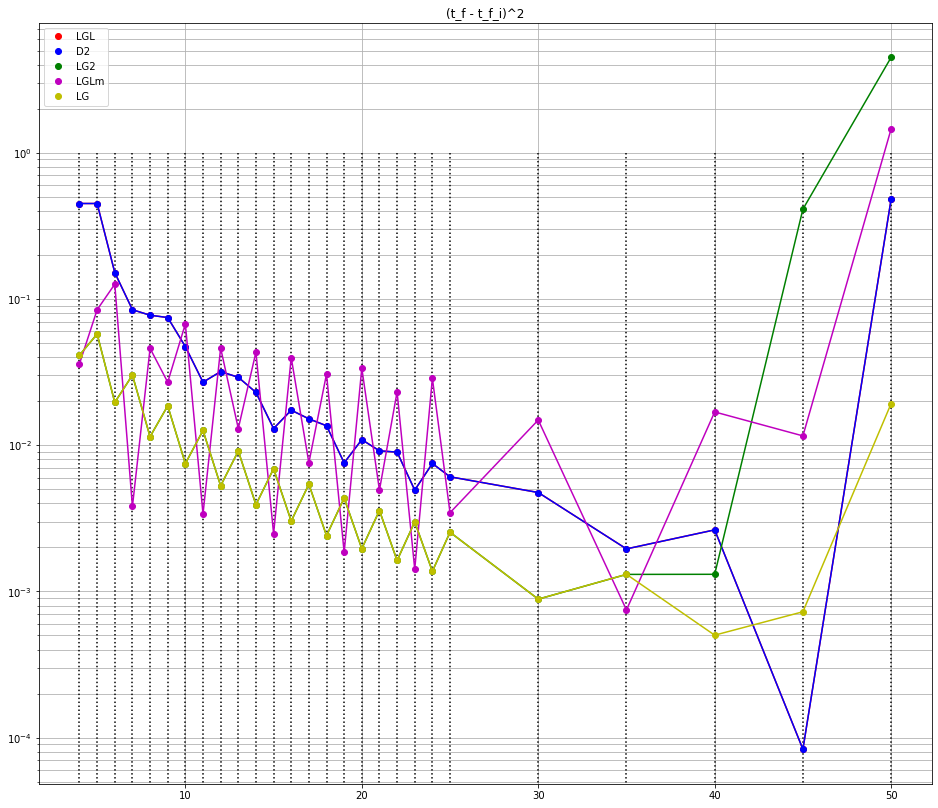

In [112]:
plt.figure(figsize=[16,14])

schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
plt.title('(t_f - t_f_i)^2')
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_bloq[scheme]['N'], np.abs(np.array(results_bloq[scheme]['t_f'])-2), color + 'o', label = scheme)
    plt.plot(results_bloq[scheme]['N'], np.abs(np.array(results_bloq[scheme]['t_f'])-2), color)
plt.grid(which='both')
plt.legend()
plt.vlines(results_bloq['LGL']['N'], 0, 1, 'k',':')
#plt.ylim([-0.1,0.5])
plt.yscale('log')

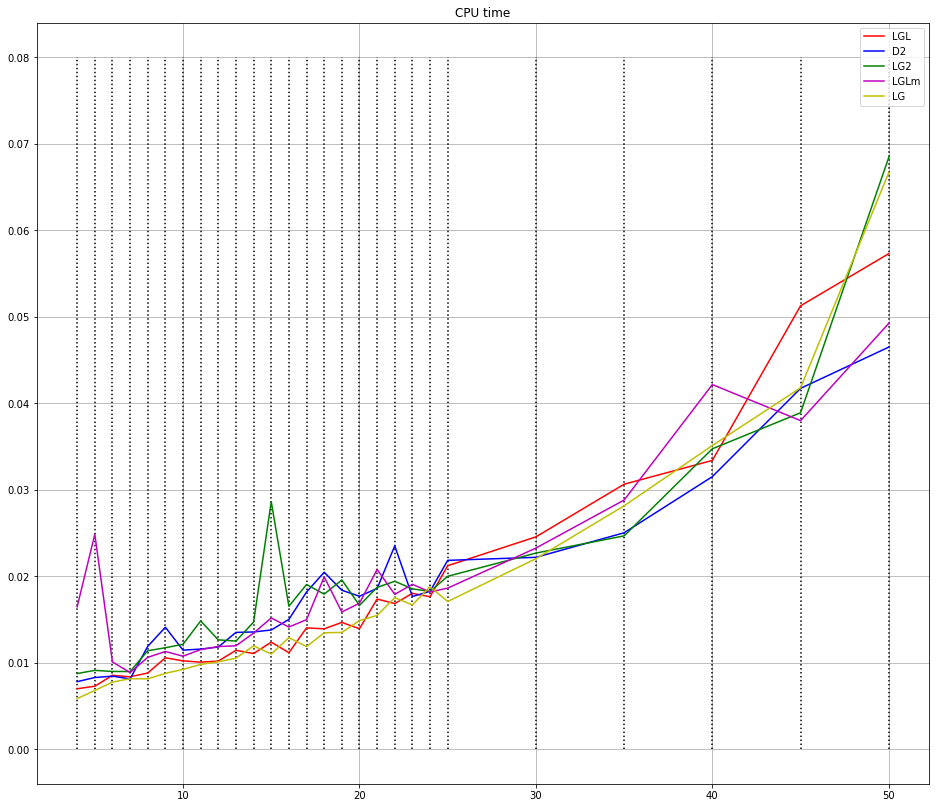

In [113]:
plt.figure(figsize=[16,14])

plt.title('CPU time')

schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['cpu_t'], color, label = scheme)
plt.grid()
plt.legend()
plt.vlines(results_bloq['LGL']['N'], 0, 0.08, 'k',':')

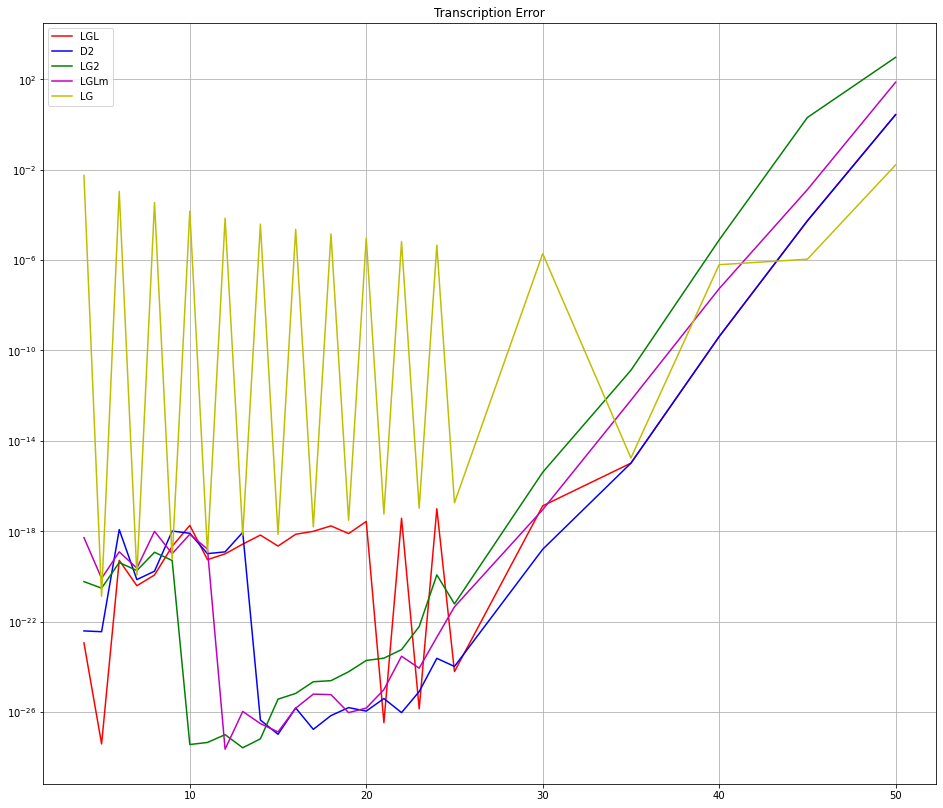

In [114]:
plt.figure(figsize=[16,14])

plt.title('Transcription Error')

schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err'], color, label = scheme)
plt.grid()
plt.legend()
plt.yscale('log')

In [ ]:
@lru_cache
def error_transcr_bloq_q(qq, vv, uu, scheme, t0, t1):
    N = len(qq)
    if scheme == 'LG2':
        tau = LG2(N, 30)
    elif scheme == 'LG':
        tau = LG_1(N, 30)
    elif scheme == 'LGLm':
        tau = LGL(N,30)
    else:
        tau = LGL(N, 30)
        
    
    pol_q = lagrangePolynomial(tau, qq)
    pol_v = lagrangePolynomial(tau, vv)
    
    pol_q_dot = 2/(t1 - t0) * pol_q.diff(x)
    
    err_q_dot_pol = (pol_q_dot-pol_v)**2
    
    t_arr = np.linspace(-1, 1, 1000)
    err_q_num = [err_q_dot_pol.evalf(n = 20, subs = {x:ii}) for ii in t_arr]
    err_q_num_int = np.trapz(np.array(err_q_num), t_arr)
    
    return err_q_num_int * (t1-t0)/2

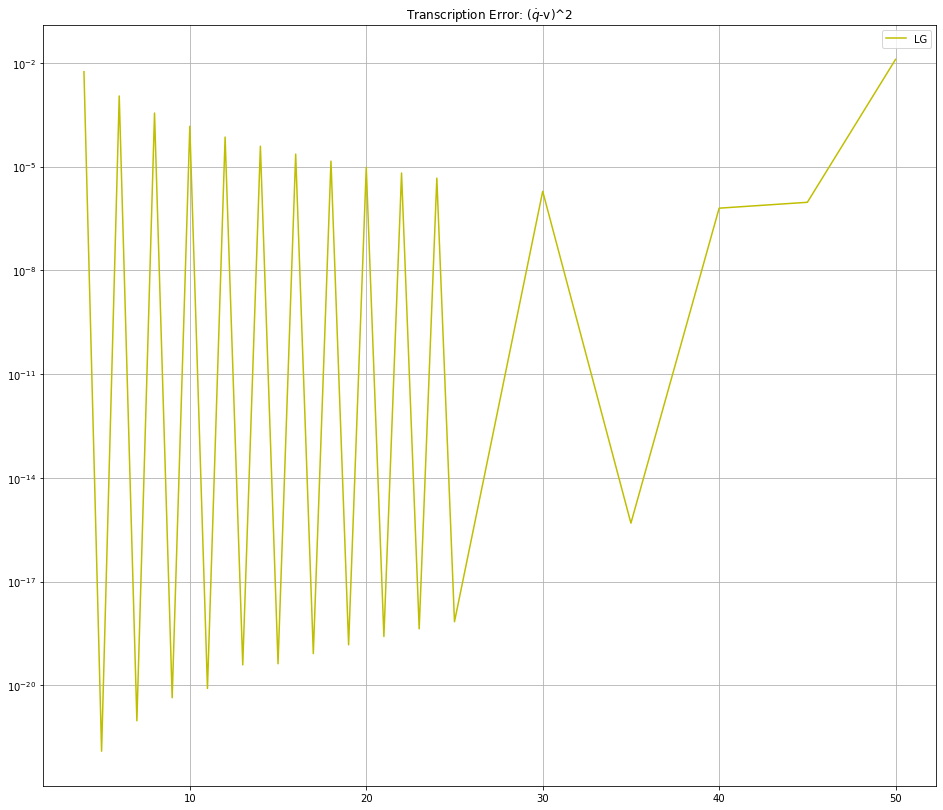

In [123]:
plt.figure(figsize=[16,14])

plt.title('Transcription Error: ($\dot q $-v)^2')

schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
#for ii in range(5):
ii = 4
scheme = schemes[ii]
color = colours[ii]
plt.plot(results_bloq[scheme]['N'], 
         [error_transcr_bloq_q(
             results_bloq[scheme]['q'][jj],
             results_bloq[scheme]['v'][jj],
             results_bloq[scheme]['u'][jj],
             scheme,
             0,
             results_bloq[scheme]['t_f'][jj])for jj in range(len(results_bloq[scheme]['N']))], 
         color, 
         label = scheme)
plt.grid()
plt.legend()
plt.yscale('log')

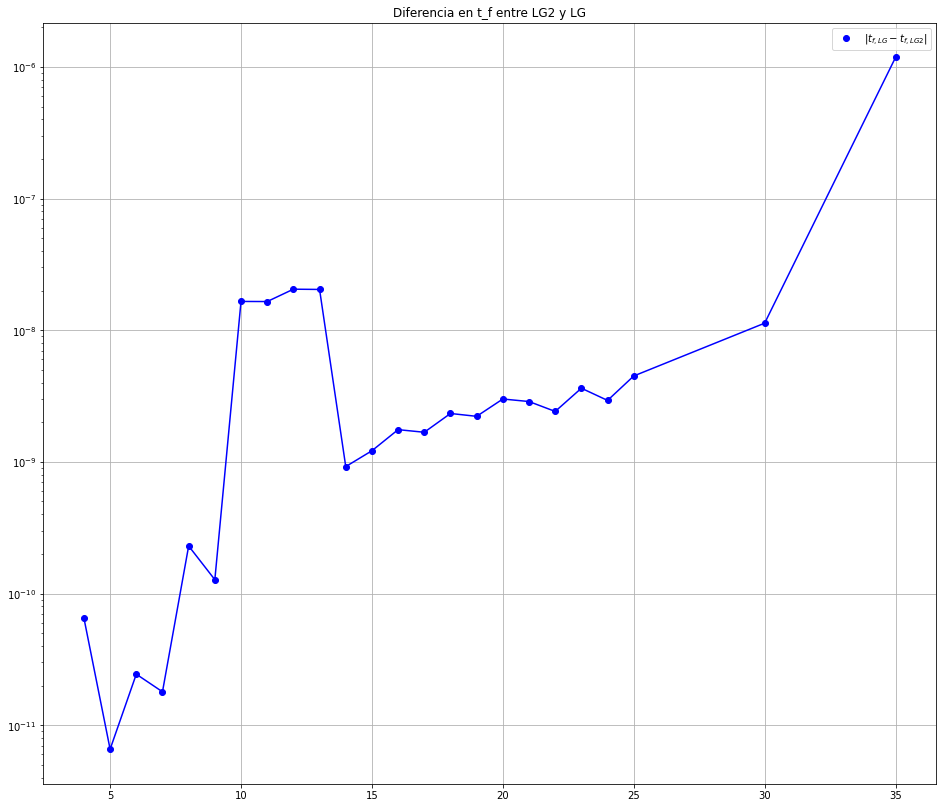

In [124]:
plt.figure(figsize=[16,14])

schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
plt.title('Diferencia en t_f entre LG2 y LG')

scheme = schemes[ii]
color = colours[1]
plt.plot(results_bloq[scheme]['N'][:-3], np.abs(np.array(results_bloq['LG']['t_f'])[:-3]-np.array(results_bloq['LG2']['t_f'])[:-3]), color + 'o', label = '$|t_{f, LG}- t_{f, LG2}|$')
plt.plot(results_bloq[scheme]['N'][:-3], np.abs(np.array(results_bloq['LG']['t_f'])[:-3]-np.array(results_bloq['LG2']['t_f'])[:-3]), color)
plt.grid()
plt.legend()
#plt.vlines(results['LGL'][4], 1, 3, 'k',':')
#plt.ylim([1.92,2.15])
plt.yscale('log')

In [141]:
def poly_u(uu, scheme):
    N = len(uu)
    if scheme == 'LG2':
        tau = LG(N, 30)
    elif scheme == 'LGLm':
        tau = LGLm(N, 30)
    elif scheme == 'LG':
        tau = LG(N, 30)
    else:
        tau = LGL(N, 30)
    return lagrangePolynomial(tau, uu)

In [126]:
def plot_u(uu, scheme, tf, color = 'k', t0 = 0, N_interp = 300):
    N = len(uu)
    if scheme == 'LG2':
        tau = LG(N, 30)
    elif scheme == 'LGLm':
        tau = LGLm(N, 30)
    elif scheme == 'LG':
        tau = LG(N, 30)
    else:
        tau = LGL(N, 30)
    coll_p_t = t_0 + (1 + np.array(tau))*(tf - t0)/2
    tau_int_arr = np.linspace(-1, 1, N_interp)
    t_int_arr = np.linspace(t0, tf, N_interp)
    
    plt.plot(coll_p_t, uu, color+'o', label = 'control '+scheme)
    if N<=50:
        u_pol = lagrangePolynomial(tau, uu)
        u_interp_f = lambdify([x,],u_pol)
        plt.plot(t_int_arr, u_interp_f(tau_int_arr), color)
    else:
        plt.plot(coll_p_t, uu, color+'--')

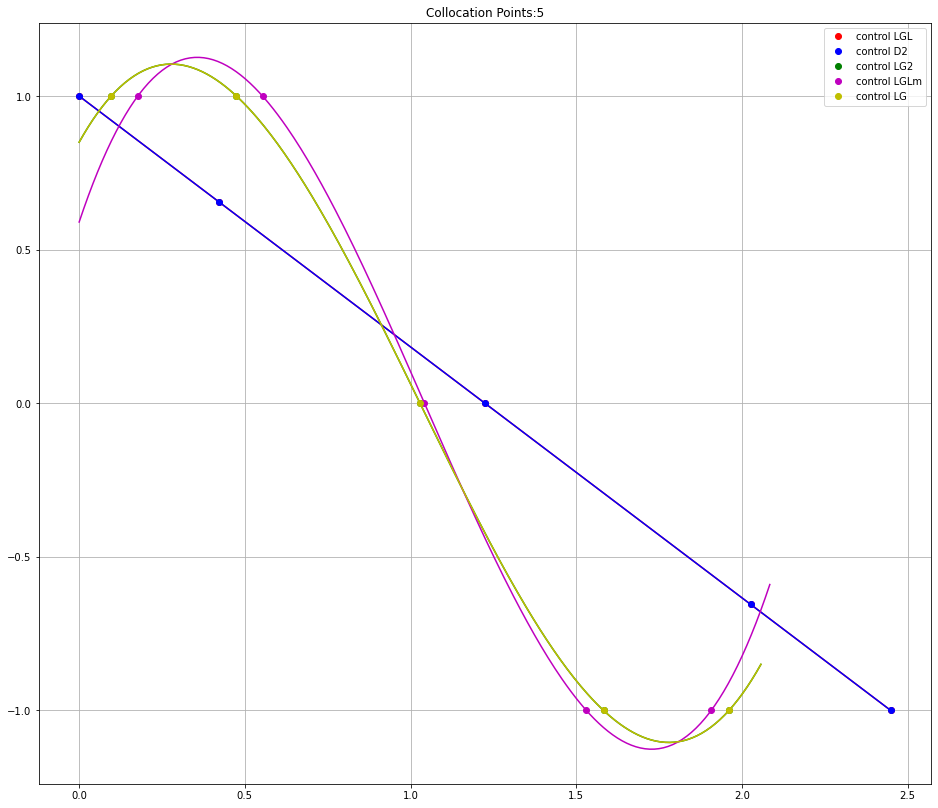

In [160]:

plt.figure(figsize=[16,14])
N_Problem = 1

schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
plt.title('Collocation Points:' + str(results_bloq['LG2']['N'][N_Problem]))
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    plot_u(
        results_bloq[scheme]['u'][N_Problem],
        scheme,
        results_bloq[scheme]['t_f'][N_Problem],
        color
    )
plt.grid()
plt.legend()

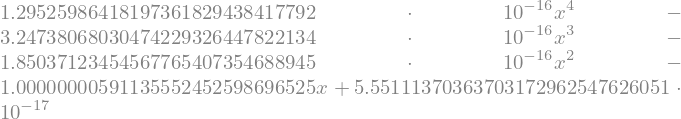

In [161]:
scheme = 'LGL'
_p_u = poly_u(
    results_bloq[scheme]['u'][1],
    scheme
)
_p_u

In [250]:
for ii in range(len(results_bloq[scheme]['N'])):
    _n = results_bloq[scheme]['N'][ii]
    print(f'\n\nN = {_n}')
    for scheme in schemes:
        _p_u = poly_u(
            results_bloq[scheme]['u'][ii],
            scheme
        )
        print(f'\n\t{scheme}')
        for jj in range(_n-1, _n-5, -1):
            print(f'x^{jj}: {"{:.1e}".format(float(_p_u.coeff(x**jj)))}\t', end='')
f'{"{:.2e}".format(_p_u.coeff(x**4))}'



N = 4

	LGL
x^3: 7.6e-17	x^2: -6.6e-16	x^1: -1.0e+00	x^0: 0.0e+00	
	D2
x^3: -2.9e-17	x^2: 3.5e-16	x^1: -1.0e+00	x^0: 0.0e+00	
	LG2
x^3: 2.8e+00	x^2: 0.0e+00	x^1: -3.3e+00	x^0: 0.0e+00	
	LGLm
x^3: -9.6e+00	x^2: 2.2e-16	x^1: 4.3e+00	x^0: 0.0e+00	
	LG
x^3: 2.8e+00	x^2: -1.8e-16	x^1: -3.3e+00	x^0: 0.0e+00	

N = 5

	LGL
x^4: 1.3e-16	x^3: -3.2e-16	x^2: -1.9e-16	x^1: -1.0e+00	
	D2
x^4: -1.4e-16	x^3: 3.0e-15	x^2: 2.0e-16	x^1: -1.0e+00	
	LG2
x^4: 3.3e-16	x^3: 1.4e+00	x^2: -3.6e-16	x^1: -2.3e+00	
	LGLm
x^4: 2.0e-16	x^3: 2.0e+00	x^2: -1.8e-16	x^1: -2.6e+00	
	LG
x^4: -2.6e-15	x^3: 1.4e+00	x^2: 2.9e-15	x^1: -2.3e+00	

N = 6

	LGL
x^5: 7.8e-16	x^4: -7.6e-15	x^3: 7.4e-01	x^2: 4.4e-15	
	D2
x^5: -3.2e-16	x^4: -1.8e-14	x^3: 7.4e-01	x^2: 1.1e-14	
	LG2
x^5: -7.4e+00	x^4: 1.8e-16	x^3: 1.1e+01	x^2: -2.3e-16	
	LGLm
x^5: -1.2e+01	x^4: 7.4e-15	x^3: 1.5e+01	x^2: -5.6e-15	
	LG
x^5: -7.4e+00	x^4: -1.4e-15	x^3: 1.1e+01	x^2: 1.7e-15	

N = 7

	LGL
x^6: 1.4e-15	x^5: 1.5e-14	x^4: -1.2e-15	x^3: 2.0e+00	
	D2
x^6: 1.4e

x^44: -2.0e+08	x^43: 1.9e+10	x^42: 2.2e+09	x^41: -2.1e+11	
	LGLm
x^44: -1.9e+09	x^43: 3.6e+10	x^42: 2.1e+10	x^41: -3.9e+11	
	LG
x^44: 4.2e+08	x^43: 1.9e+10	x^42: -4.7e+09	x^41: -2.1e+11	

N = 50

	LGL
x^49: -3.1e-02	x^48: -4.7e+00	x^47: 1.9e+10	x^46: -2.6e+09	
	D2
x^49: -1.8e-02	x^48: 1.9e+00	x^47: 1.9e+10	x^46: -2.6e+09	
	LG2
x^49: 1.2e+13	x^48: 2.1e+11	x^47: -1.5e+14	x^46: -2.3e+12	
	LGLm
x^49: -1.5e+14	x^48: -1.6e+11	x^47: 1.8e+15	x^46: 1.9e+12	
	LG
x^49: -1.5e+13	x^48: -3.2e+11	x^47: 1.9e+14	x^46: 3.7e+12	

'-9.65e+1'

In [128]:
def plot_q(qq, scheme, tf, color = 'k', t0 = 0, N_interp = 300):
    N = len(qq)
    if scheme == 'LG2':
        tau = LG2(N, 30)
    elif scheme == 'LGLm':
        tau = LGL(N, 30)
    elif scheme == 'LG':
        tau = LG_1(N, 30)
    else:
        tau = LGL(N, 30)
    int_p_t = t_0 + (1 + np.array(tau))*(tf - t0)/2
    tau_int_arr = np.linspace(-1, 1, N_interp)
    t_int_arr = np.linspace(t0, tf, N_interp)
    
    plt.plot(int_p_t, qq, color+'o', label = 'q '+scheme)
    if N<=50:
        q_pol = lagrangePolynomial(tau, qq)
        q_interp_f = lambdify([x,],q_pol)
        plt.plot(t_int_arr, q_interp_f(tau_int_arr), color)
    else:
        plt.plot(coll_p_t, qq, color+'--')
    return q_pol

LGL , len q: 6
D2 , len q: 6
LG2 , len q: 8
LGLm , len q: 8
LG , len q: 7


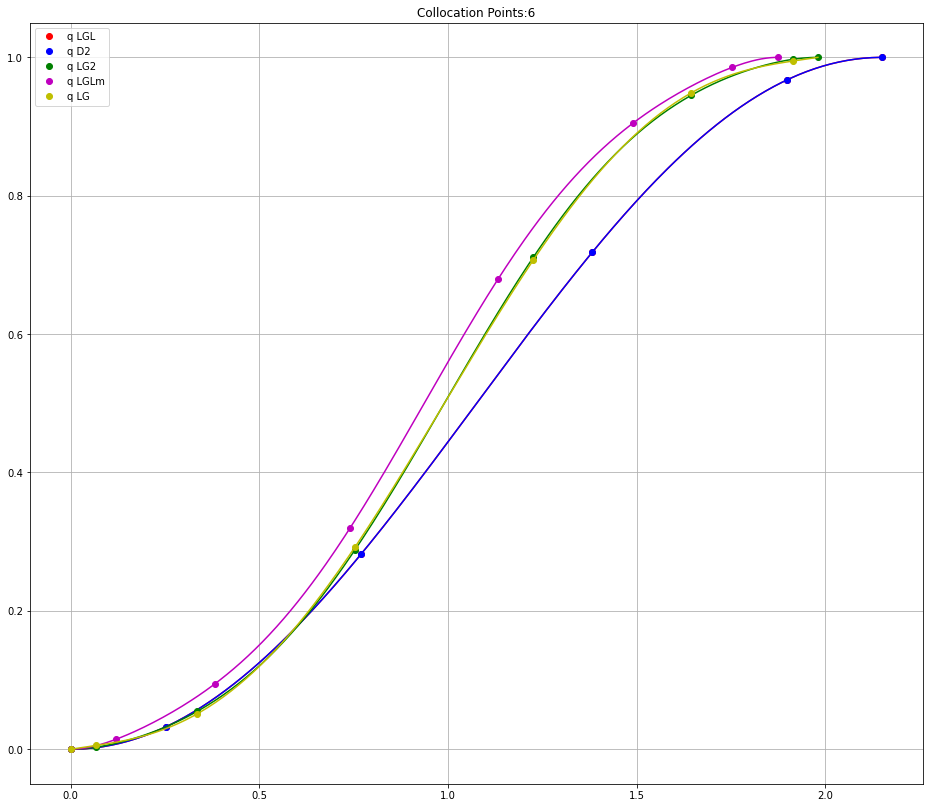

In [129]:

plt.figure(figsize=[16,14])
N_Problem = 2

schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
plt.title('Collocation Points:' + str(results_bloq['LGL']['N'][N_Problem]))
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    plot_q(
        results_bloq[scheme]['q'][N_Problem],
        scheme,
        results_bloq[scheme]['t_f'][N_Problem],
        color
    )
    print(scheme, ', len q:', len(results_bloq[scheme]['q'][N_Problem]))
plt.grid()
plt.legend()

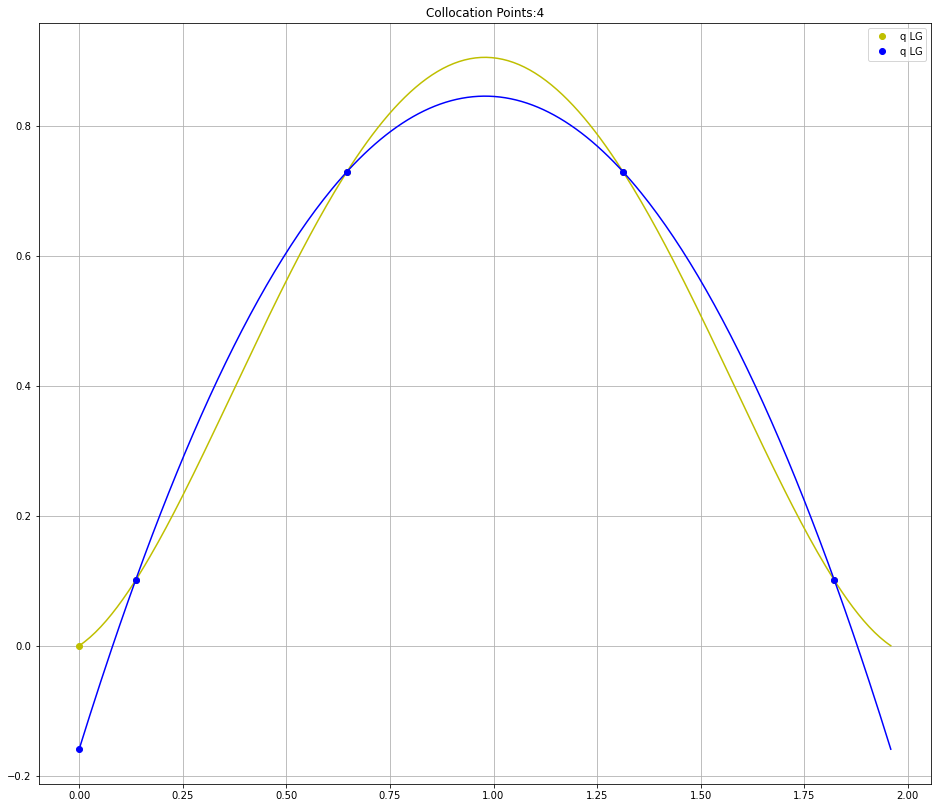

In [130]:

plt.figure(figsize=[16,14])
N_Problem = 0

schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
plt.title('Collocation Points:' + str(results_bloq['LGL']['N'][N_Problem]))
#for ii in range(5):
scheme = schemes[4]
_v_b = 2/(results_bloq[scheme]['t_f'][N_Problem]) *matrix_D_LG_1(results_bloq[scheme]['N'][N_Problem],20) @ results_bloq[scheme]['q'][N_Problem]
_pol_1 = plot_q(
    results_bloq[scheme]['v'][N_Problem],
    scheme,
    results_bloq[scheme]['t_f'][N_Problem],
    color
)
_pol_2 = plot_q(
    _v_b,
    scheme,
    results_bloq[scheme]['t_f'][N_Problem],
    'b'
)
plt.grid()
plt.legend()

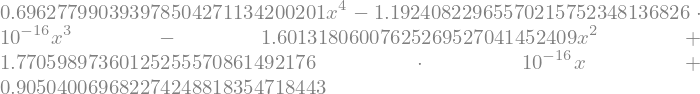

In [131]:
_pol_1

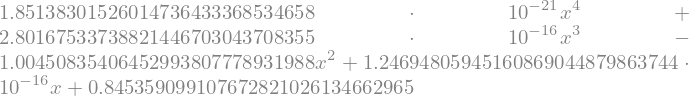

In [132]:
_pol_2

In [ ]:
def find_der_polyline(x_n, xp, yp):
    n = np.searchsorted(xp, x_n)
    n = np.where(n-1>0, n-1, 0)
    deriv_arr = (yp[1:] - yp[:-1])/(xp[1:] - xp[:-1])
    return deriv_arr[n]


def error_transcr_bloq_interp(qq, vv, uu, t0, t1, scheme = 'LGL'):
    N = len(qq)
    if scheme == 'LGL':
        tau = LGL(N)
    elif scheme == 'D2':
        tau = LGL(N)
    elif scheme == 'LG2':
        tau = LG2(N)
        uu = np.array([uu[0]] + list(uu) + [uu[-1]],dtype='float64')
    elif scheme == 'LG':
        tau = LG_1(N) + [1]
        uu = np.array([uu[0]] + list(uu) + [uu[-1]],dtype='float64')
        endp_f = LG_1_end_p_fun_cas(N, 20)
        qq_1 = float(endp_f(qq))
        vv_1 = float(endp_f(vv))
        qq = np.array(list(qq) + [qq_1,],dtype='float64')
        vv = np.array(list(vv) + [vv_1,],dtype='float64')
    elif scheme == 'LGLm':
        tau = LGL(N)
        uu = np.array([uu[0]] + list(uu) + [uu[-1]])
    
    coll_p = t_0 + (1 + np.array(tau,dtype='float64'))*(t1 - t0)/2
    t_arr = np.linspace(t0, t1, 1000)
    
    qq_int = np.interp(t_arr, coll_p, qq)
    vv_int = np.interp(t_arr, coll_p, vv)
    uu_int = np.interp(t_arr, coll_p, uu)
    
    qq_dot_int = find_der_polyline(t_arr, coll_p, qq)
    vv_dot_int = find_der_polyline(t_arr, coll_p, vv)
    
    err_q_dot = (qq_dot_int - vv_int)**2
    err_v_dot = (vv_dot_int - uu_int)**2
    
    
    err_q = np.trapz(err_q_dot, t_arr)
    err_v = np.trapz(err_v_dot, t_arr)
    
    return err_q + err_v

[t_f_list , cpudt_list ,trun_err_list, uu_sol_list, test_N, qq_sol_list,vv_sol_list]

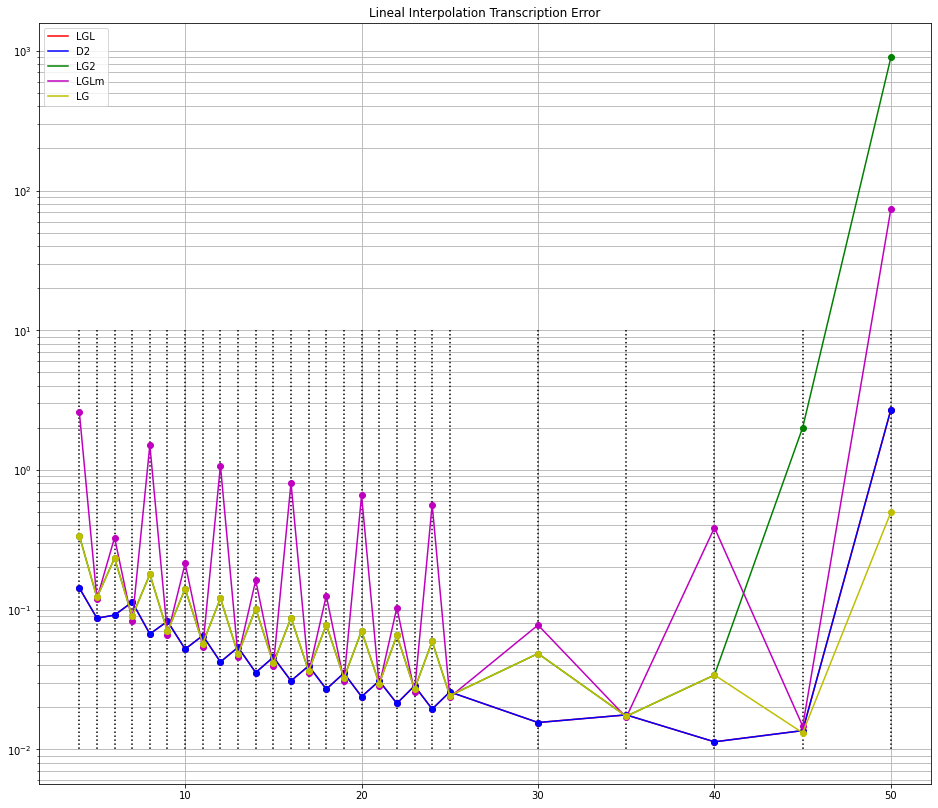

In [134]:
plt.figure(figsize=[16,14])

plt.title('Lineal Interpolation Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_bloq[scheme]['N']
    if not 'tr_err_lin' in results_bloq[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            #print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr_bloq_interp(
                results_bloq[scheme]['q'][jj],
                results_bloq[scheme]['v'][jj],
                results_bloq[scheme]['u'][jj],
                0.,
                results_bloq[scheme]['t_f'][jj],
                scheme))
        results_bloq[scheme]['tr_err_lin'] = lite
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_lin'], color, alpha = 1)
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_lin'], 'o' + color, alpha = 1)
plt.grid(which='both')
plt.legend()
plt.yscale('log')
plt.vlines(results_bloq['LGL']['N'], 10, 1e-2, 'k',':')

In [137]:
from scipy.interpolate import CubicHermiteSpline as hermite

In [ ]:
#@lru_cache
def error_transcr_bloq_interp_hermite(qq, vv, uu, t0, t1, scheme = 'LGL'):
    N = len(qq)
    if scheme == 'LGL':
        tau = LGL(N)
    elif scheme == 'D2':
        tau = LGL(N)
    elif scheme == 'LG2':
        tau = LG2(N)
        uu = np.array([uu[0]] + list(uu) + [uu[-1]],dtype='float64')
    elif scheme == 'LG':
        tau = LG_1(N) + [1]
        uu = np.array([uu[0]] + list(uu) + [uu[-1]],dtype='float64')
        endp_f = LG_1_end_p_fun_cas(N, 20)
        qq_1 = float(endp_f(qq))
        vv_1 = float(endp_f(vv))
        qq = np.array(list(qq) + [qq_1,],dtype='float64')
        vv = np.array(list(vv) + [vv_1,],dtype='float64')
    elif scheme == 'LGLm':
        tau = LGL(N)
        uu = np.array([uu[0]] + list(uu) + [uu[-1]])
    
    coll_p = t_0 + (1 + np.array(tau,dtype='float64'))*(t1 - t0)/2
    t_arr = np.linspace(t0, t1, 1000)
    #print('uu: ', uu.dtype, uu.shape, uu)
    #print('qq shape:',qq.shape, 'coll points shape: ',coll_p.shape)
    qq_int = hermite(coll_p, qq, vv)(t_arr)
    vv_int = hermite(coll_p, vv, uu)(t_arr)
    uu_int = np.interp(t_arr, coll_p, uu)
    
    qq_dot_int = np.gradient(qq_int, t_arr)
    vv_dot_int = np.gradient(vv_int, t_arr)
    
    err_q_dot = (qq_dot_int - vv_int)**2
    err_v_dot = (vv_dot_int - uu_int)**2
    #plt.figure(figsize=[16,14])
    #plt.plot(t_arr, err_v_dot)
    #plt.grid()
    #plt.title(scheme + ' ' +str(N))
    
    err_q = np.trapz(err_q_dot, t_arr)
    err_v = np.trapz(err_v_dot, t_arr)
    #print('err_q:', err_q, 'err_v: ', err_v)
    
    return err_v #err_q + 

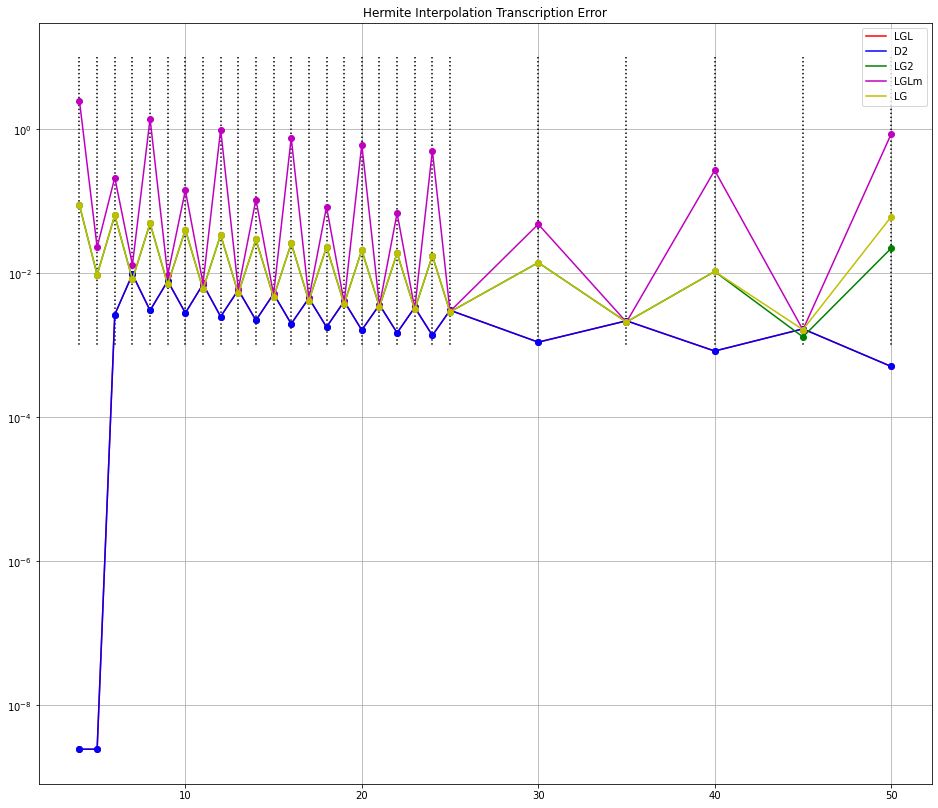

In [139]:
plt.figure(figsize=[16,14])

plt.title('Hermite Interpolation Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_bloq[scheme]['N']
    if not 'tr_err_hs' in results_bloq[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            #print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr_bloq_interp_hermite(
                results_bloq[scheme]['q'][jj],
                results_bloq[scheme]['v'][jj],
                results_bloq[scheme]['u'][jj],
                0.,
                results_bloq[scheme]['t_f'][jj],
                scheme))
    
        results_bloq[scheme]['tr_err_hs'] = lite
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_hs'], 'o' + color, alpha = 1)
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_hs'], color, label = scheme, alpha = 1)
plt.grid(which='both')
plt.legend()
plt.yscale('log')
plt.vlines(results_bloq['LGL']['N'], 10, 1e-3, 'k',':')

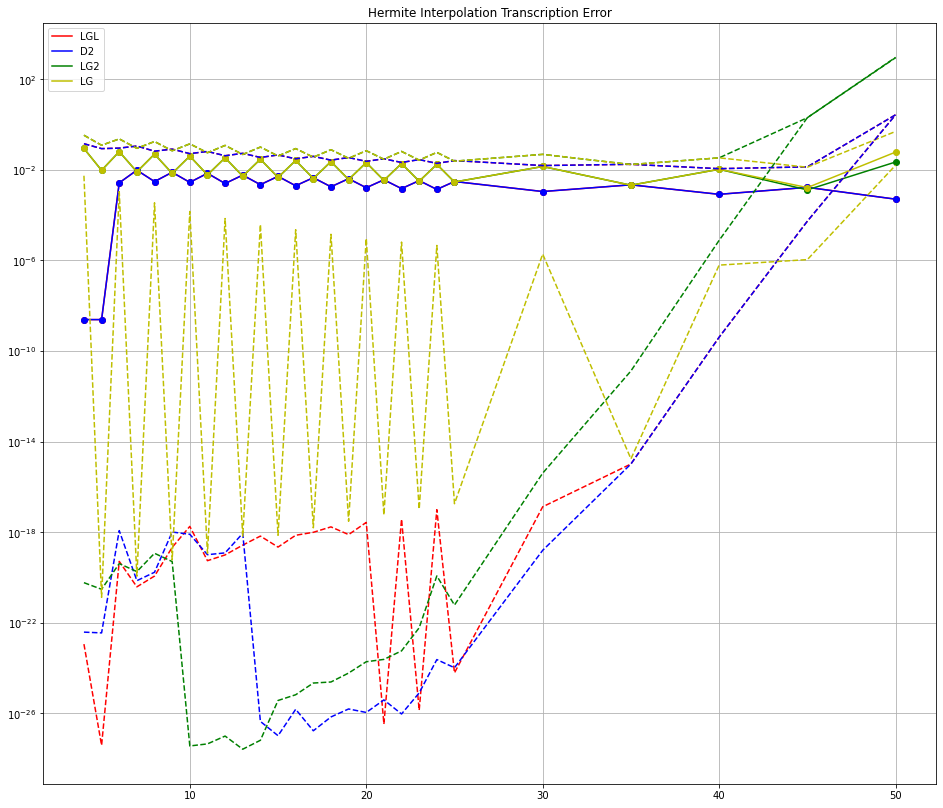

In [266]:
plt.figure(figsize=[16,14])

plt.title('Hermite Interpolation Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm',
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_bloq[scheme]['N']
    if not 'tr_err_hs' in results_bloq[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            #print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr_bloq_interp_hermite(
                results_bloq[scheme]['q'][jj],
                results_bloq[scheme]['v'][jj],
                results_bloq[scheme]['u'][jj],
                0.,
                results_bloq[scheme]['t_f'][jj],
                scheme))
        results_bloq[scheme]['tr_err_hs'] = lite
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_hs'], 'o' + color, alpha = 1)
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_hs'], color, label = scheme, alpha = 1)
    
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_bloq[scheme]['N']
    if not 'tr_err_lin' in results_bloq[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            #print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr_bloq_interp(
                results_bloq[scheme]['q'][jj],
                results_bloq[scheme]['v'][jj],
                results_bloq[scheme]['u'][jj],
                0.,
                results_bloq[scheme]['t_f'][jj],
                scheme))
        results_bloq[scheme]['tr_err_lin'] = lite
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_lin'], '--' + color, alpha = 1)
    
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err'], '--' + color)
    
plt.grid(which='both')
plt.legend()
plt.yscale('log')
#plt.ylim(0,0.2)
#plt.vlines(results['LGL'][4], 2, 2e-28, 'k',':')

In [241]:
#@lru_cache
def error_transcr_bloq_u_lin(qq, vv, uu, t0, t1, scheme = 'LGL'):
    N = len(qq)
    if scheme == 'LGL':
        tau = LGL(N)
    elif scheme == 'D2':
        tau = LGL(N)
    elif scheme == 'LG2':
        tau = LG2(N)
        uu = np.array([uu[0]] + list(uu) + [uu[-1]],dtype='float64')
    elif scheme == 'LG':
        tau = LG_1(N) + [1]
        uu = np.array([uu[0]] + list(uu) + [uu[-1]],dtype='float64')
        endp_f = LG_1_end_p_fun_cas(N, 20)
        qq_1 = float(endp_f(qq))
        vv_1 = float(endp_f(vv))
        qq = np.array(list(qq) + [qq_1,],dtype='float64')
        vv = np.array(list(vv) + [vv_1,],dtype='float64')
    elif scheme == 'LGLm':
        tau = LGL(N)
        uu = np.array([uu[0]] + list(uu) + [uu[-1]])
        
    coll_p = t_0 + (1 + np.array(tau,dtype='float64'))*(t1 - t0)/2
    t_arr = np.linspace(-1, 1, 1000)
    
    pol_q = lagrangePolynomial(tau, qq)
    pol_v = lagrangePolynomial(tau, vv)
    
    pol_q_dot = 2/(t1 - t0) * pol_q.diff(x)
    pol_v_dot = 2/(t1 - t0) * pol_v.diff(x)
    
    
    uu_int = np.interp(t_arr, tau, uu)
    
    
    
    vv_dot_int = np.array([pol_v_dot.evalf(n = 20, subs = {x:ii}) for ii in t_arr],dtype='float64')
    err_v_dot = (vv_dot_int - uu_int)**2
    err_v = np.trapz(err_v_dot, t_arr)
    
    err_q_dot_pol = (pol_q_dot-pol_v)**2
    
    err_q_num = [err_q_dot_pol.evalf(n = 20, subs = {x:ii}) for ii in t_arr]
    err_q_num_int = np.trapz(np.array(err_q_num), t_arr)
    
    
    return (err_q_num_int + err_v) * (t1-t0)/2

results_bloq['LG'].pop('tr_err_u_lin')

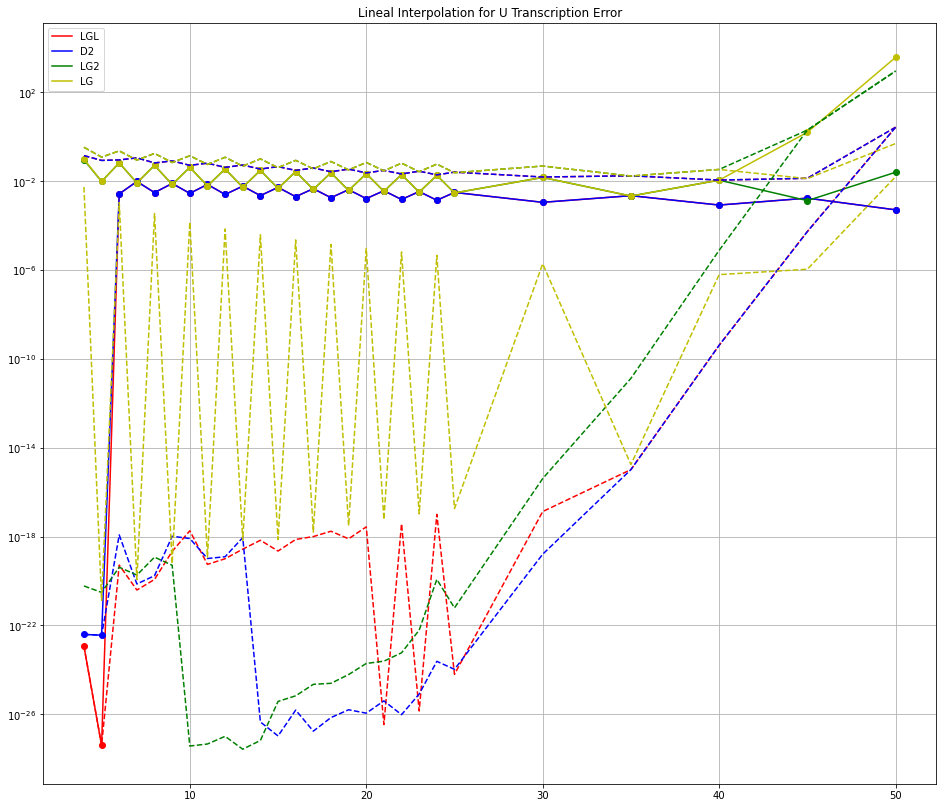

In [270]:
plt.figure(figsize=[16,14])

plt.title('Lineal Interpolation for U Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LG']#, 'LGLm'
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_bloq[scheme]['N']
    if not 'tr_err_u_lin' in results_bloq[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr_bloq_u_lin(
                results_bloq[scheme]['q'][jj],
                results_bloq[scheme]['v'][jj],
                results_bloq[scheme]['u'][jj],
                0.,
                results_bloq[scheme]['t_f'][jj],
                scheme))
        results_bloq[scheme]['tr_err_u_lin'] = lite
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_u_lin'], 'o' + color, alpha = 1)
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_u_lin'], color, label = scheme, alpha = 1)
    
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_bloq[scheme]['N']
    if not 'tr_err_lin' in results_bloq[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr_bloq_interp(
                results_bloq[scheme]['q'][jj],
                results_bloq[scheme]['v'][jj],
                results_bloq[scheme]['u'][jj],
                0.,
                results_bloq[scheme]['t_f'][jj],
                scheme))
        results_bloq[scheme]['tr_err_lin'] = lite
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_lin'], '--' + color, alpha = 1)
    
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err'], '--' + color)
    
plt.grid(which='both')
plt.legend()
plt.yscale('log')
#plt.ylim(0, 0.2)
#plt.vlines(results['LGL'][4], 2, 2e-28, 'k',':')

In [273]:
def error_transcr_bloq_q_lin(qq, vv, uu, t0, t1, scheme = 'LGL'):
    N = len(qq)
    if scheme == 'LGL':
        tau = LGL(N)
        pol_u = lagrangePolynomial(tau, uu)
    elif scheme == 'D2':
        tau = LGL(N)
        pol_u = lagrangePolynomial(tau, uu)
    elif scheme == 'LG2':
        tau = LG2(N)
        pol_u = lagrangePolynomial(LG(N-2, 30), uu)
        
    elif scheme == 'LG':
        tau = LG_1(N) + [1]
        pol_u = lagrangePolynomial(LG(N-1, 30), uu)
        endp_f = LG_1_end_p_fun_cas(N, 20)
        qq_1 = float(endp_f(qq))
        vv_1 = float(endp_f(vv))
        qq = np.array(list(qq) + [qq_1,],dtype='float64')
        vv = np.array(list(vv) + [vv_1,],dtype='float64')
    elif scheme == 'LGLm':
        tau = LGL(N)
        pol_u = lagrangePolynomial(LGLm(N-2, 30), uu)
        
    tau_arr = np.linspace(-1, 1, 1000)
    uu_int = np.array([pol_u.evalf(n = 20, subs = {x:ii}) for ii in tau_arr],dtype='float64')
    
    coll_p = t_0 + (1 + np.array(tau,dtype='float64'))*(t1 - t0)/2
    t_arr = np.linspace(t0, t1, 1000)
    
    qq_int = np.interp(t_arr, coll_p, qq)
    vv_int = np.interp(t_arr, coll_p, vv)

    
    qq_dot_int = find_der_polyline(t_arr, coll_p, qq)
    vv_dot_int = find_der_polyline(t_arr, coll_p, vv)
    
    err_q_dot = (qq_dot_int - vv_int)**2
    err_v_dot = (vv_dot_int - uu_int)**2
    
    
    err_q = np.trapz(err_q_dot, t_arr)
    err_v = np.trapz(err_v_dot, t_arr)
    
    return err_q + err_v


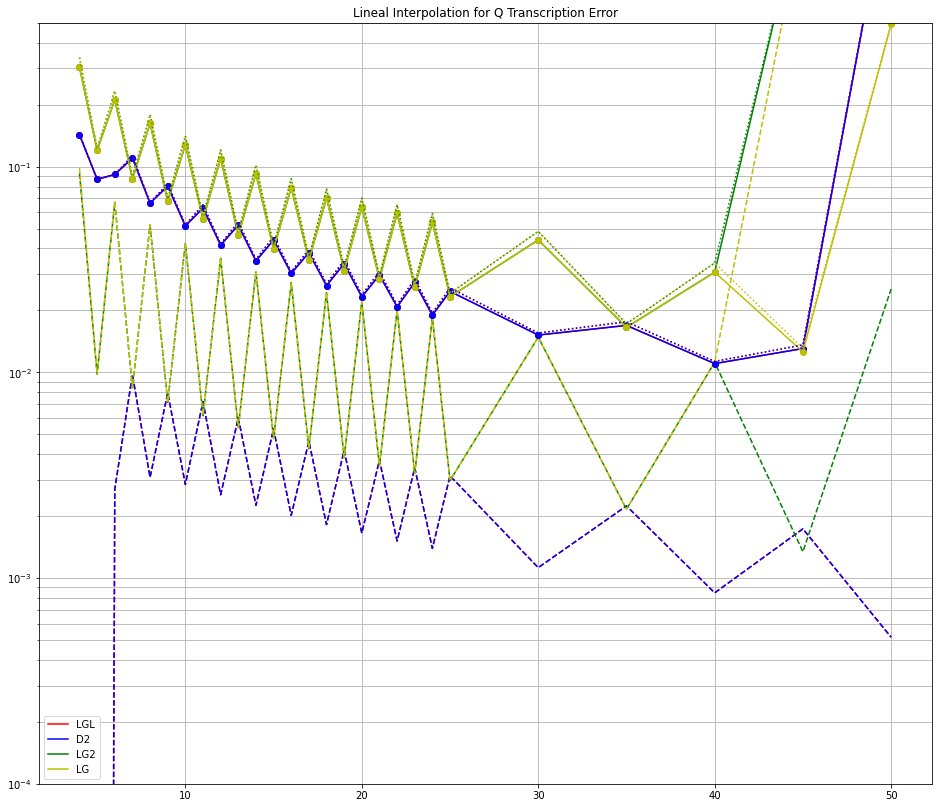

In [280]:
plt.figure(figsize=[16,14])

plt.title('Lineal Interpolation for Q Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LG']#, 'LGLm'
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_bloq[scheme]['N']
    if not 'tr_err_u_lin' in results_bloq[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr_bloq_u_lin(
                results_bloq[scheme]['q'][jj],
                results_bloq[scheme]['v'][jj],
                results_bloq[scheme]['u'][jj],
                0.,
                results_bloq[scheme]['t_f'][jj],
                scheme))
        results_bloq[scheme]['tr_err_u_lin'] = lite
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_u_lin'], '--' + color, alpha = 1)
    
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_bloq[scheme]['N']
    if not 'tr_err_q_lin' in results_bloq[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr_bloq_q_lin(
                results_bloq[scheme]['q'][jj],
                results_bloq[scheme]['v'][jj],
                results_bloq[scheme]['u'][jj],
                0.,
                results_bloq[scheme]['t_f'][jj],
                scheme))
        results_bloq[scheme]['tr_err_q_lin'] = lite
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_q_lin'], 'o' + color, alpha = 1)
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_q_lin'], color, label = scheme, alpha = 1)

for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_bloq[scheme]['N']
    if not 'tr_err_lin' in results_bloq[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr_bloq_interp(
                results_bloq[scheme]['q'][jj],
                results_bloq[scheme]['v'][jj],
                results_bloq[scheme]['u'][jj],
                0.,
                results_bloq[scheme]['t_f'][jj],
                scheme))
        results_bloq[scheme]['tr_err_lin'] = lite
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_lin'], ':' + color, alpha = 1)
    
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    #plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err'], '--' + color)
    
plt.grid(which='both')
plt.legend()
plt.yscale('log')
plt.ylim(1e-4, 0.5)
#plt.vlines(results['LGL'][4], 2, 2e-28, 'k',':')

opt_LGL_bloq_u(8)

test_N = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,30,35,40,45,50]
plt.figure(figsize=[16,14])
N_Problem = 3
schemes = ['LGL', 'D2', 'LG2']
colours = ['r', 'b', 'g']
plt.title('Collocation Points:' + str(test_N[N_Problem]))
for ii in range(3):
    scheme = schemes[ii]
    color = colours[ii]
    plot_u(
        results[scheme][3][N_Problem],
        scheme,
        results[scheme][0][N_Problem],
        color
    )
plot_u
plt.grid()
plt.legend()

## Problema: Swing up del péndulo:

$$
\begin{split}\begin{array}{lc}
\begin{array}{l}
\text{minimize:} \\
x(\cdot) \in \mathbb{R}^2, \, u(\cdot) \in \mathbb{R}
\end{array}
\quad \displaystyle t_f
\\
\\
\text{subject to:} \\
\\
\begin{array}{ll}
\left\{
\begin{array}{l}
\dot{x}_0 = x_1 \\
\dot{x}_1 = u - sin(x_0) \\
-u_{max} \le u \le u_{max} , \quad
\end{array} \right. & \text{for} \, 0 \le t \le T \\
x_0(0)=0, \quad x_1(0)=0, x_0(T) = pi/2 , x_1(T) = 0
\end{array}
\end{array}\end{split}
$$
with $T=10$.

siendo $$x_0 = \theta$$ $$x_1 = \theta'$$

In [197]:
@lru_cache
def obj_f_u_LGL_pend(N, precission = 20):
    coefs = symbols(f'c_0:{N}')
    pol_lag = lagrangePolynomial(LGL(N, precission), coefs)
    res = integrate(cos(pol_lag), [x, -1, 1])
    return lambdify(coefs, res)

@lru_cache
def obj_f_u_LG2_pend(N, precission = 20):
    coefs = symbols(f'c_0:{N}')
    pol_lag = lagrangePolynomial(LG(N, precission), coefs)
    res = integrate(cos(pol_lag), [x, -1, 1])
    return lambdify(coefs, res)

In [198]:
x_sym = cas.SX.sym('x', 2)
x_dot_sym = cas.SX.sym('x_dot', 2)
u_sym = cas.SX.sym('u',1)

dynam_f_x_pend = cas.Function(
    "dynamics_x",
    [x_sym, x_dot_sym, u_sym],
    [x_dot_sym[1]-(u_sym-cas.sin(x_sym[0]))]
)

In [199]:
q_sym = cas.SX.sym('q', 1)
q_dot_sym = cas.SX.sym('q_dot', 1)
q_dot_dot_sym = cas.SX.sym('q_dot_dot', 1)
u_sym = cas.SX.sym('u',1)

dynam_f_q_pend = cas.Function(
    "dynamics_q",
    [q_sym, q_dot_sym, q_dot_dot_sym, u_sym],
    [q_dot_dot_sym-(u_sym - cas.sin(q_sym))]
)

In [ ]:
@lru_cache
def error_transcr_pend(qq, vv, uu, scheme, t0, t1):
    N = len(qq)
    if scheme == 'LG2':
        tau = LG2(N, 30)
        pol_u = lagrangePolynomial(LG(N-2, 30), uu)
    elif scheme == 'LG':
        tau = LG_1(N, 30)
        pol_u = lagrangePolynomial(LG(N-1, 30), uu)
    elif scheme == 'LGLm':
        tau = LGL(N,30)
        pol_u = lagrangePolynomial(LGLm(N-2, 30), uu)
    else:
        tau = LGL(N, 30)
        pol_u = lagrangePolynomial(tau, uu)
        
    
    pol_q = lagrangePolynomial(tau, qq)
    pol_v = lagrangePolynomial(tau, vv)
    
    pol_q_dot = 2/(t1 - t0) * pol_q.diff(x)
    pol_v_dot = 2/(t1 - t0) * pol_v.diff(x)
    
    err_q_dot_pol = (pol_q_dot-pol_v)**2
    err_v_dot_pol = (pol_v_dot-(pol_u - sin(pol_q)))**2
    
    t_arr = np.linspace(-1, 1, 1000)
    err_q_num = [err_q_dot_pol.evalf(n = 20, subs = {x:ii}) for ii in t_arr]
    err_q_num_int = np.trapz(np.array(err_q_num), t_arr)
    err_v_num = [err_v_dot_pol.evalf(n = 20, subs = {x:ii}) for ii in t_arr]
    err_v_num_int = np.trapz(np.array(err_v_num), t_arr)
    
    return (err_q_num_int + err_v_num_int) * (t1-t0)/2

In [201]:
def plot_x(qq, scheme, tf, color = 'k', t0 = 0, N_interp = 300, label = 'q'):
    N = len(qq)
    if scheme == 'LG2':
        tau = LG2(N, 30)
    else:
        tau = LGL(N, 30)
    coll_p_t = t_0 + (1 + np.array(tau))*(tf - t0)/2
    tau_int_arr = np.linspace(-1, 1, N_interp)
    t_int_arr = np.linspace(t0, tf, N_interp)
    
    plt.plot(coll_p_t, qq, color+'o', label = label + ' ' +scheme)
    if N<=50:
        q_pol = lagrangePolynomial(tau, qq)
        q_interp_f = lambdify([x,],q_pol)
        plt.plot(t_int_arr, q_interp_f(tau_int_arr), color)
    else:
        plt.plot(coll_p_t, qq, color+'--')

In [202]:
@lru_cache
def t_const_pend(col_points = 7, scheme = 'LGL', solve_repetitions = 2, precission = 20):
    opti = cas.Opti()
    opts = {'ipopt.print_level':0, 'print_time':0}
    opti.solver('ipopt', opts)
    
    opt_dict = {
        'LGL': [
            col_points,
            LGL,
            matrix_D_1
        ],
        'D2': [
            col_points,
            LGL,
            matrix_D_1
        ],
        'LG2': [
            col_points+2,
            LG2,
            matrix_D_LG2
        ],
        'LGLm': [
            col_points+2,
            LGLm,
            matrix_D_1
        ],
        'LG': [
            col_points+1,
            LG_1,
            matrix_D_LG_1
        ]
    }
    sch_options = opt_dict[scheme]
    N = sch_options[0]
    
    if scheme == 'LGL' or scheme == 'LG':
        x_opti = opti.variable(N,2)
    else:
        x_opti = opti.variable(N)
    
    u_opti = opti.variable(col_points)
    tau_arr = sch_options[1](N, 20)
    t_f = opti.variable(1)
    #t_f = 10
    t_0 = 0
    u_lim = opti.parameter(1)
    
    D_mat = sympy2casadi(sch_options[2](N-1,precission), [], [])
    x_dot_opti = 2/(t_f - t_0) * D_mat@x_opti
    x_dot_dot_opti = 2/(t_f - t_0) * D_mat@x_dot_opti

    #cost = cas.sum1(u_opti**2)
    #f_obj = obj_f_u_LG2(N)
    #cost = f_obj(*cas.vertsplit(u_opti))
    cost = t_f
    #if scheme == 'LGL':
    #    cost = cas.sum1(cas.cos(x_opti[:,0]))
        #cost_f = obj_f_u_LGL_pend(N, precission = 20)
        #cost = cost_f(x_opti[:,0])
    #else:
    #    cost = cas.sum1(cas.cos(x_opti[:]))
        #cost_f = obj_f_u_LGL_pend(N, precission = 20)
        #cost = cost_f(x_opti[:])
    opti.minimize(cost)
         
    opti.subject_to(t_f > 0)   
    if scheme == 'LGL':
        opti.subject_to(x_opti[0,:].T == [0., 0.])
        opti.subject_to(x_opti[-1,:].T == [np.pi/2 ,0.])
        for ii in range(N):
            opti.subject_to(dynam_f_x_pend(x_opti[ii,:], x_dot_opti[ii,:], u_opti[ii,:])==0)
            opti.subject_to(x_opti[ii,1] == x_dot_opti[ii,0])
    if scheme == 'LG':
        endp_f = LG_1_end_p_fun_cas(N, precission)
        opti.subject_to(x_opti[0,:].T == [0., 0.])
        opti.subject_to(endp_f(x_opti[:,0]) == np.pi/2)
        opti.subject_to(endp_f(x_opti[:,1]) == 0.)
        #opti.subject_to(x_opti[0,1] == x_dot_opti[0,0])
        for ii in range(1, N):
            opti.subject_to(dynam_f_x_pend(x_opti[ii,:], x_dot_opti[ii,:], u_opti[ii-1,:])==0)
            opti.subject_to(x_opti[ii,1] == x_dot_opti[ii,0])
    elif scheme == 'D2':
        opti.subject_to(x_opti[0] == [0.])
        opti.subject_to(x_opti[-1] == [np.pi/2])
        opti.subject_to(x_dot_opti[0] == [0.])
        opti.subject_to(x_dot_opti[-1] == [0.])
        for ii in range(N):
            opti.subject_to(dynam_f_q_pend(x_opti[ii], x_dot_opti[ii], x_dot_dot_opti[ii], u_opti[ii,:])==0)
    elif scheme == 'LG2':
        opti.subject_to(x_opti[0] == [0.])
        opti.subject_to(x_opti[-1] == [np.pi/2])
        opti.subject_to(x_dot_opti[0] == [0.])
        opti.subject_to(x_dot_opti[-1] == [0.])
        for ii in range(1, N-1):
            opti.subject_to(dynam_f_q_pend(x_opti[ii], x_dot_opti[ii], x_dot_dot_opti[ii], u_opti[ii-1,:])==0)
    elif scheme == 'LGLm':
        opti.subject_to(x_opti[0] == [0.])
        opti.subject_to(x_opti[-1] == [np.pi/2])
        opti.subject_to(x_dot_opti[0] == [0.])
        opti.subject_to(x_dot_opti[-1] == [0.])
        for ii in range(1, N-1):
            opti.subject_to(dynam_f_q_pend(x_opti[ii], x_dot_opti[ii], x_dot_dot_opti[ii], u_opti[ii-1,:])==0)


    
    for ii in range(col_points):
        opti.subject_to(u_opti[ii] <= u_lim[0])
        opti.subject_to(-u_lim[0] <= u_opti[ii])

    opti.set_value(u_lim, 0.5)
    opti.set_initial(t_f, 10.)
    #opti.set_initial(u_opti, list(np.linspace(-1,1,col_points)))
    
    cput0 = time.time()
    for ii in range(solve_repetitions):
        sol = opti.solve()
    cput1 = time.time()
    cpudt = (cput1-cput0)/solve_repetitions
    
    xx_sol = sol.value(x_opti)
    uu_sol = sol.value(u_opti)
    t_f_sol = sol.value(t_f)
    D_mat = np.array(D_mat)

    t_arr = t_0 + (1 + np.array(tau_arr))*(t_f_sol - t_0)/2
    
    if scheme == 'LGL':
        qq_sol = xx_sol[:,0]
        vv_sol = xx_sol[:,1]
        #q_pol = lagrangePolynomial(t_arr, xx_sol[:,0])
        #v_pol = lagrangePolynomial(t_arr, xx_sol[:,1])
        #u_pol = lagrangePolynomial(t_arr, uu_sol[:])
    elif scheme == 'LG':
        qq_sol = xx_sol[:,0]
        vv_sol = xx_sol[:,1]
        #q_pol = lagrangePolynomial(t_arr, xx_sol[:,0])
        #v_pol = lagrangePolynomial(t_arr, xx_sol[:,1])
        #u_pol = lagrangePolynomial(t_arr, uu_sol[:])
    elif scheme == 'D2':
        qq_sol = xx_sol
        vv_sol = 2/(t_f_sol - t_0) * D_mat@qq_sol
        #q_pol = lagrangePolynomial(t_arr, xx_sol[:])
        #v_pol = lagrangePolynomial(t_arr, xx_sol[:]).diff(x)
        #u_pol = lagrangePolynomial(t_arr, uu_sol[:])
    elif scheme == 'LG2':
        qq_sol = xx_sol
        vv_sol = 2/(t_f_sol - t_0) * D_mat@qq_sol
        #coll_p_t = t_0 + (1 + np.array(LG(col_points)))*(t_f_sol - t_0)/2
        #q_pol = lagrangePolynomial(t_arr, xx_sol[:])
        #v_pol = lagrangePolynomial(t_arr, xx_sol[:]).diff(x)
        #u_pol = lagrangePolynomial(coll_p_t, uu_sol[:])
    elif scheme == 'LGLm':
        qq_sol = xx_sol
        vv_sol = 2/(t_f_sol - t_0) * D_mat@qq_sol
        #coll_p_t = t_0 + (1 + np.array(LGLm(col_points)))*(t_f_sol - t_0)/2
        #q_pol = lagrangePolynomial(t_arr, xx_sol[:])
        #v_pol = lagrangePolynomial(t_arr, xx_sol[:]).diff(x)
        #u_pol = lagrangePolynomial(coll_p_t, uu_sol[:])
        
    trun_err = error_transcr_pend(qq_sol, vv_sol, uu_sol, scheme, t_0, t_f_sol)
    
    return t_f_sol, cpudt, trun_err, uu_sol, qq_sol, vv_sol

In [203]:
if not 'results_pend' in globals():
    results_pend = {}
test_N = [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,30,40]
#test_N = [6,7]#,8,9,10,11,12,13]
for scheme in ['LG','LGLm','LGL', 'D2', 'LG2']:
    print(f'\n\t\t NUEVO ESQUEMA: {scheme}\n')
    t_f_list = []
    cpudt_list = []
    tran_err_list = []
    uu_sol_list = []
    qq_sol_list = []
    vv_sol_list = []
    for N_col in test_N:
        print(f' Problema: {N_col} Collocation Points')
        time.sleep(0.01)
        t_f_sol, cpudt, tran_err, uu_sol, qq_sol, vv_sol = t_const_pend(col_points = N_col,
                                              scheme = scheme,
                                              solve_repetitions = 5,
                                              precission = 20)
        t_f_list.append(t_f_sol)
        cpudt_list.append(cpudt)
        tran_err_list.append(tran_err)
        uu_sol_list.append(uu_sol)
        qq_sol_list.append(qq_sol)
        vv_sol_list.append(vv_sol)
    results_pend[scheme] = {
        't_f': t_f_list ,
        'cpu_t' : cpudt_list ,
        'tr_err' : tran_err_list,
        'u' : uu_sol_list,
        'N' : test_N,
        'q' : qq_sol_list,
        'v' : vv_sol_list}


		 NUEVO ESQUEMA: LG

 Problema: 6 Collocation Points
 Problema: 7 Collocation Points
 Problema: 8 Collocation Points
 Problema: 9 Collocation Points
 Problema: 10 Collocation Points
 Problema: 11 Collocation Points
 Problema: 12 Collocation Points
 Problema: 13 Collocation Points
 Problema: 14 Collocation Points
 Problema: 15 Collocation Points
 Problema: 16 Collocation Points
 Problema: 17 Collocation Points
 Problema: 18 Collocation Points
 Problema: 19 Collocation Points
 Problema: 20 Collocation Points
 Problema: 21 Collocation Points
 Problema: 22 Collocation Points
 Problema: 23 Collocation Points
 Problema: 24 Collocation Points
 Problema: 25 Collocation Points
 Problema: 30 Collocation Points
 Problema: 40 Collocation Points

		 NUEVO ESQUEMA: LGLm

 Problema: 6 Collocation Points
 Problema: 7 Collocation Points
 Problema: 8 Collocation Points
 Problema: 9 Collocation Points
 Problema: 10 Collocation Points
 Problema: 11 Collocation Points
 Problema: 12 Collocation Points
 Pr

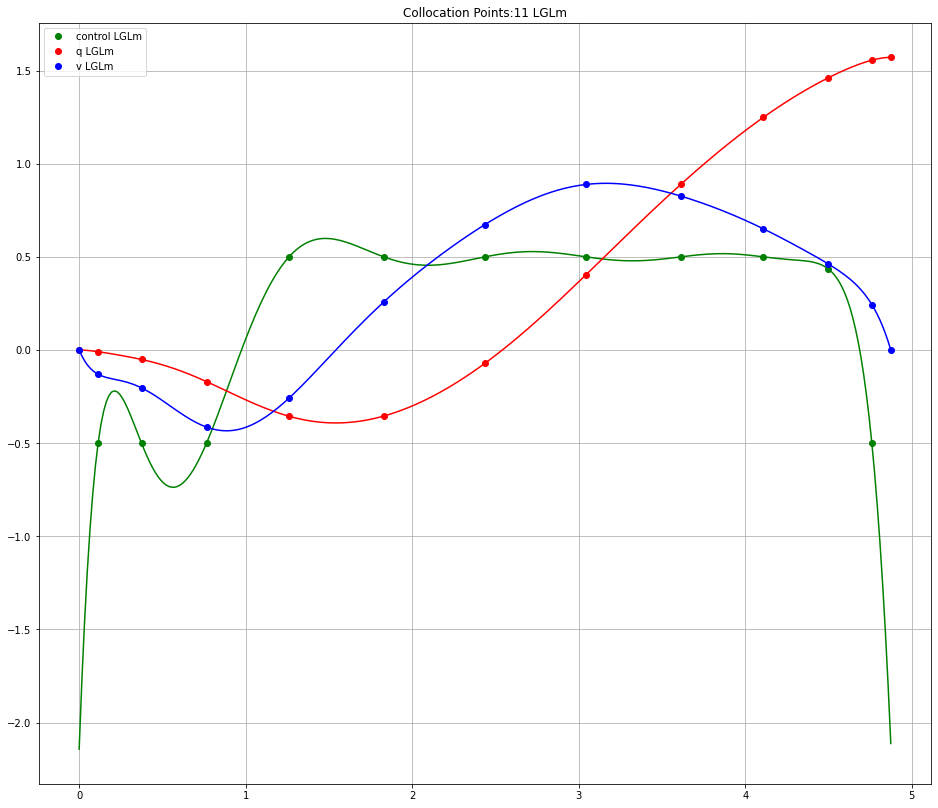

In [204]:
plt.figure(figsize=[16,14])
N_Problem = 5
schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
ii = 3
scheme = schemes[ii]
plt.title('Collocation Points:' + str(results_pend[scheme]['N'][N_Problem]) + ' ' + scheme)
color = colours[ii]
plot_u(
    results_pend[scheme]['u'][N_Problem],
    scheme,
    t_f_sol,
    'g'
)
plot_x(
    results_pend[scheme]['q'][N_Problem],
    scheme,
    t_f_sol,
    'r'
)
plot_x(
    results_pend[scheme]['v'][N_Problem],
    scheme,
    t_f_sol,
    'b',
    label = 'v'
)
plt.grid()
plt.legend()

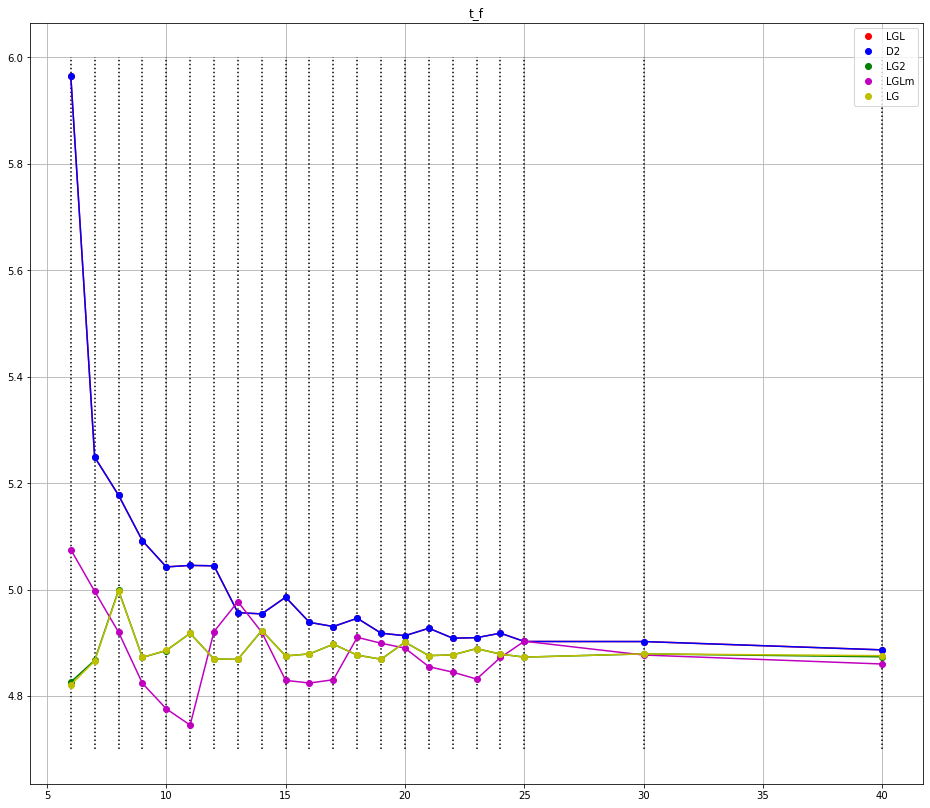

In [205]:
plt.figure(figsize=[16,14])


plt.title('t_f')
schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
for ii in range(5):
    scheme = schemes[ii]
    quality = results_pend[scheme]['t_f']#[np.mean(np.cos(ii)) for ii in results_pend[scheme][4]]
    color = colours[ii]
    plt.plot(results_pend[scheme]['N'], quality, color + 'o', label = scheme, alpha = 1)
    plt.plot(results_pend[scheme]['N'], quality, color, alpha = 1)
plt.grid()
plt.legend()
plt.vlines(results_pend['LGL']['N'], 4.7, 6, 'k',':')
#plt.ylim([1.92,2.15])

In [251]:
for ii in range(len(results_pend[scheme]['N'])):
    _n = results_pend[scheme]['N'][ii]
    print(f'\n\nN = {_n}')
    for scheme in schemes:
        _p_u = poly_u(
            results_pend[scheme]['u'][ii],
            scheme
        )
        print(f'\n\t{scheme}')
        for jj in range(_n-1, _n-5, -1):
            print(f'x^{jj}: {"{:.1e}".format(float(_p_u.coeff(x**jj)))}\t', end='')
f'{"{:.2e}".format(_p_u.coeff(x**4))}'



N = 6

	LGL
x^5: -3.8e-02	x^4: -1.1e+00	x^3: -9.9e-01	x^2: 3.6e-01	
	D2
x^5: -3.8e-02	x^4: -1.1e+00	x^3: -9.9e-01	x^2: 3.6e-01	
	LG2
x^5: -4.1e+00	x^4: -1.0e-01	x^3: 3.8e+00	x^2: -1.1e+00	
	LGLm
x^5: -5.9e+00	x^4: 1.3e+00	x^3: 5.1e+00	x^2: -2.1e+00	
	LG
x^5: -4.1e+00	x^4: -1.2e-01	x^3: 3.8e+00	x^2: -1.1e+00	

N = 7

	LGL
x^6: 1.4e+00	x^5: 8.1e-01	x^4: -9.2e-01	x^3: -1.2e+00	
	D2
x^6: 1.4e+00	x^5: 8.1e-01	x^4: -9.2e-01	x^3: -1.2e+00	
	LG2
x^6: 3.1e+00	x^5: -4.3e+00	x^4: -4.6e+00	x^3: 4.8e+00	
	LGLm
x^6: -3.6e+00	x^5: -3.6e+00	x^4: 4.1e+00	x^3: 2.4e+00	
	LG
x^6: 3.1e+00	x^5: -4.3e+00	x^4: -4.6e+00	x^3: 4.8e+00	

N = 8

	LGL
x^7: -5.0e-01	x^6: 9.8e-01	x^5: -3.3e+00	x^4: -3.4e-01	
	D2
x^7: -5.0e-01	x^6: 9.8e-01	x^5: -3.3e+00	x^4: -3.4e-01	
	LG2
x^7: 1.0e+01	x^6: -1.3e+00	x^5: -1.8e+01	x^4: 2.6e+00	
	LGLm
x^7: 1.1e+00	x^6: -3.5e+00	x^5: -5.9e+00	x^4: 4.2e+00	
	LG
x^7: 1.1e+01	x^6: -1.2e+00	x^5: -1.9e+01	x^4: 2.6e+00	

N = 9

	LGL
x^8: -2.6e-01	x^7: -7.0e-01	x^6: 3.9e+00	x^5: -3.5e+00	
	D2

'2.44e+3'

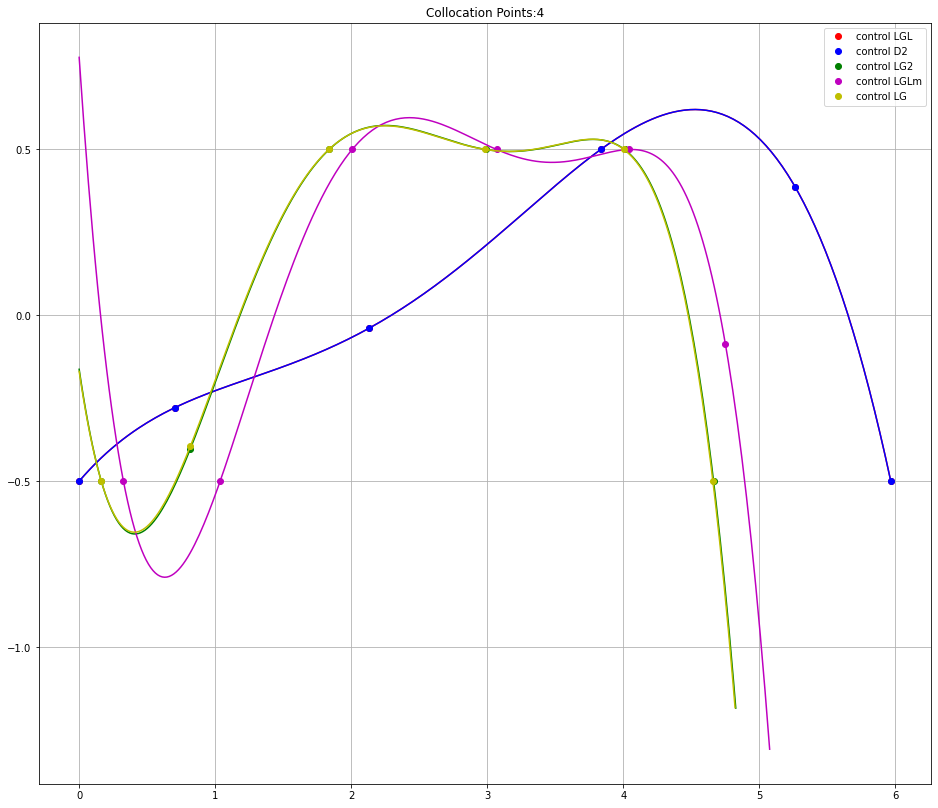

In [252]:

plt.figure(figsize=[16,14])
N_Problem = 0

schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
plt.title('Collocation Points:' + str(test_N[N_Problem]))
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    plot_u(
        results_pend[scheme]['u'][N_Problem],
        scheme,
        results_pend[scheme]['t_f'][N_Problem],
        color
    )
plt.grid()
plt.legend()

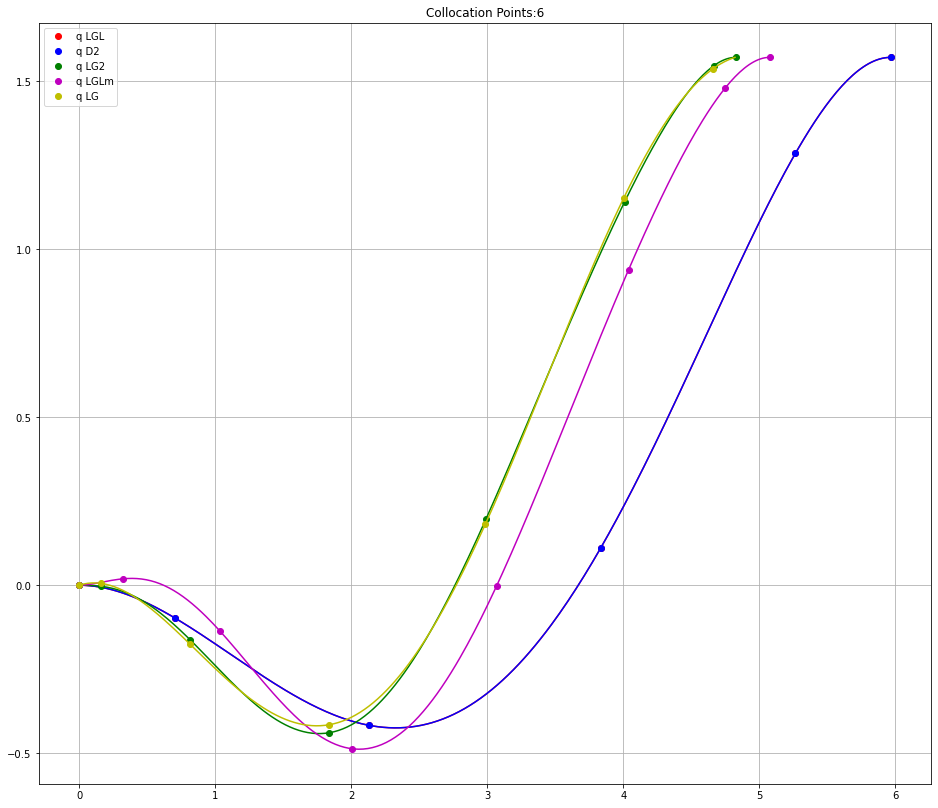

In [207]:

plt.figure(figsize=[16,14])
N_Problem = 0

schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
plt.title('Collocation Points:' + str(test_N[N_Problem]))
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    plot_q(
        results_pend[scheme]['q'][N_Problem],
        scheme,
        results_pend[scheme]['t_f'][N_Problem],
        color
    )
    
plt.grid()
plt.legend()

In [208]:
len(results_pend[scheme]['N'])

In [209]:
len(results_pend[scheme]['tr_err'])

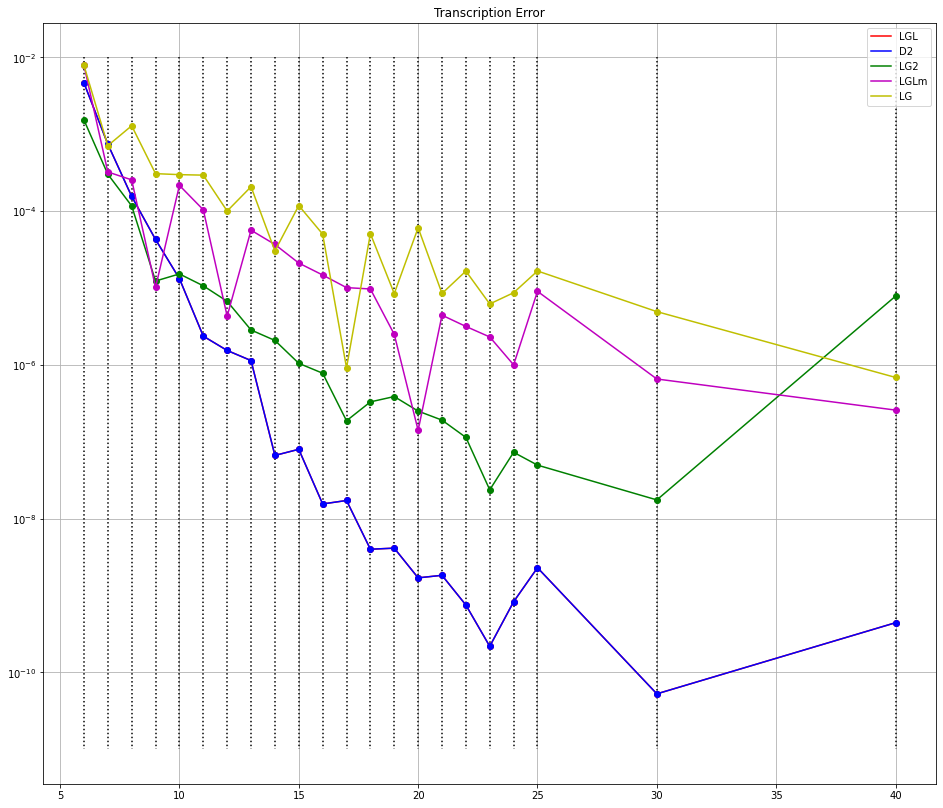

In [210]:
plt.figure(figsize=[16,14])

plt.title('Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err'], 'o' + color, alpha = 1)
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err'], color, label = scheme, alpha = 1)
plt.grid()
plt.legend()
plt.yscale('log')
plt.vlines(results_pend['LGL']['N'], 1e-2, 1e-11, 'k',':')

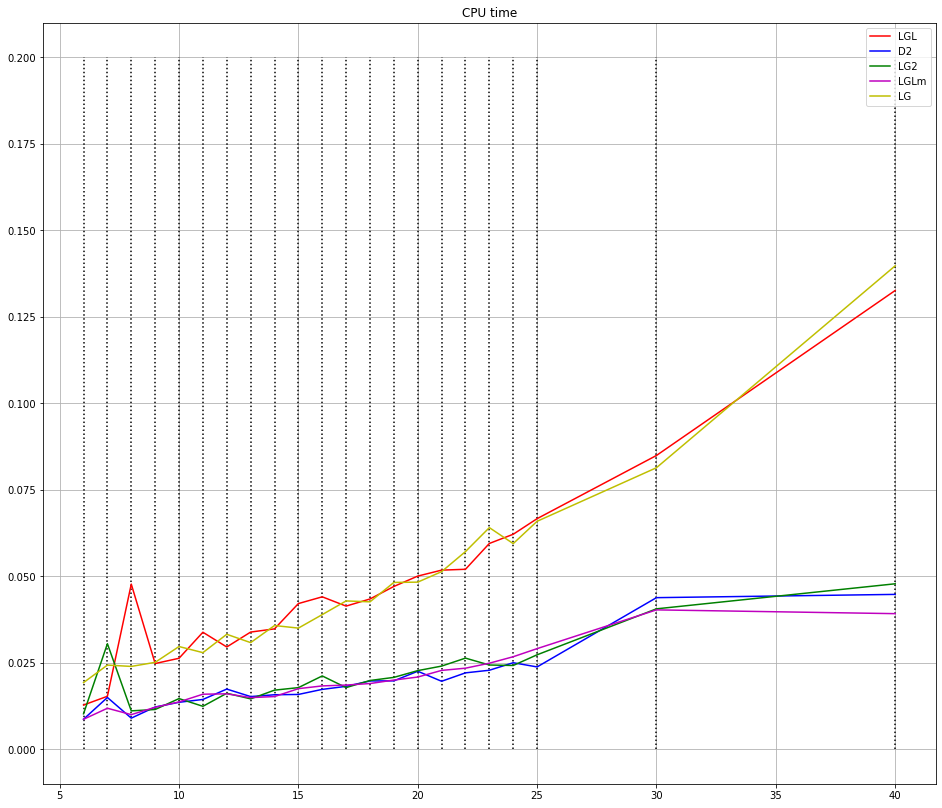

In [211]:
plt.figure(figsize=[16,14])
plt.title('CPU time')
schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['cpu_t'], color, label = scheme)
plt.grid()
plt.legend()
plt.vlines(results_pend['LGL']['N'], 0, 0.2, 'k',':')
#plt.yscale('log')

In [253]:
def find_der_polyline(x_n, xp, yp):
    n = np.searchsorted(xp, x_n)
    n = np.where(n-1>0, n-1, 0)
    deriv_arr = (yp[1:] - yp[:-1])/(xp[1:] - xp[:-1])
    return deriv_arr[n]

#@lru_cache
def error_transcr_pend_interp(qq, vv, uu, t0, t1, scheme = 'LGL'):
    N = len(qq)
    if scheme == 'LGL':
        tau = LGL(N)
    elif scheme == 'D2':
        tau = LGL(N)
    elif scheme == 'LG2':
        tau = LG2(N)
        uu = np.array([uu[0]] + list(uu) + [uu[-1]],dtype='float64')
    elif scheme == 'LG':
        tau = LG_1(N) + [1]
        uu = np.array([uu[0]] + list(uu) + [uu[-1]],dtype='float64')
        endp_f = LG_1_end_p_fun_cas(N, 20)
        qq_1 = float(endp_f(qq))
        vv_1 = float(endp_f(vv))
        qq = np.array(list(qq) + [qq_1,],dtype='float64')
        vv = np.array(list(vv) + [vv_1,],dtype='float64')
    elif scheme == 'LGLm':
        tau = LGL(N)
        uu = np.array([uu[0]] + list(uu) + [uu[-1]])
    
    coll_p = t_0 + (1 + np.array(tau,dtype='float64'))*(t1 - t0)/2
    t_arr = np.linspace(t0, t1, 1000)
    
    qq_int = np.interp(t_arr, coll_p, qq)
    vv_int = np.interp(t_arr, coll_p, vv)
    uu_int = np.interp(t_arr, coll_p, uu)
    
    qq_dot_int = find_der_polyline(t_arr, coll_p, qq)
    vv_dot_int = find_der_polyline(t_arr, coll_p, vv)
    
    err_q_dot = (qq_dot_int - vv_int)**2
    err_v_dot = (vv_dot_int-(uu_int - np.sin(qq_int)))**2
    
    
    err_q = np.trapz(err_q_dot, t_arr)
    err_v = np.trapz(err_v_dot, t_arr)
    
    return err_q + err_v

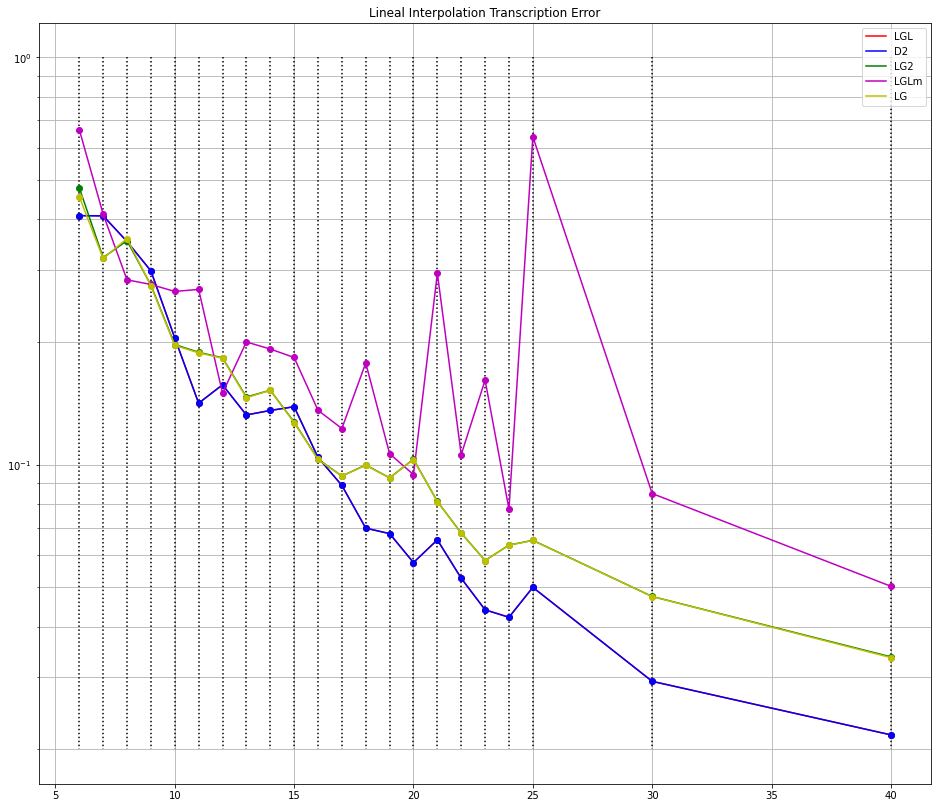

In [213]:
plt.figure(figsize=[16,14])

plt.title('Lineal Interpolation Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    lite = []
    test_N = results_pend[scheme]['N']
    for jj in range(len(test_N)):
        #print('scheme: ', scheme, ' N: ', test_N[jj])
        lite.append(error_transcr_pend_interp(
            results_pend[scheme]['q'][jj],
            results_pend[scheme]['v'][jj],
            results_pend[scheme]['u'][jj],
            0.,
            results_pend[scheme]['t_f'][jj],
            scheme))
    
    plt.plot(results_pend[scheme]['N'], lite, 'o' + color, alpha = 1)
    plt.plot(results_pend[scheme]['N'], lite, color, label = scheme, alpha = 1)
plt.grid(which='both')
plt.legend()
plt.yscale('log')
plt.vlines(results_pend['LGL']['N'], 1, 2e-2, 'k',':')

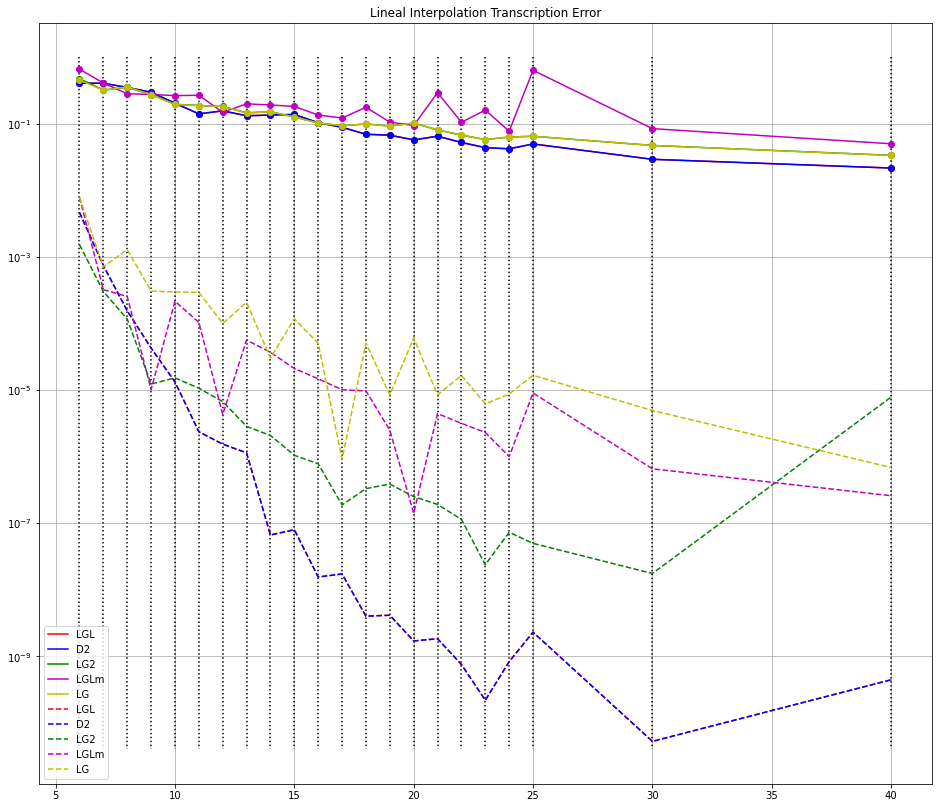

In [214]:
plt.figure(figsize=[16,14])

plt.title('Lineal Interpolation Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    lite = []
    test_N = results_pend[scheme]['N']
    for jj in range(len(test_N)):
        #print('scheme: ', scheme, ' N: ', test_N[jj])
        lite.append(error_transcr_pend_interp(
            results_pend[scheme]['q'][jj],
            results_pend[scheme]['v'][jj],
            results_pend[scheme]['u'][jj],
            0.,
            results_pend[scheme]['t_f'][jj],
            scheme))
    
    plt.plot(results_pend[scheme]['N'], lite, 'o' + color, alpha = 1)
    plt.plot(results_pend[scheme]['N'], lite, color, label = scheme, alpha = 1)
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err'], color + '--', label = scheme, alpha = 1)
plt.grid(which='both')
plt.legend()
plt.yscale('log')
plt.vlines(results_pend['LGL']['N'], 1, 4e-11, 'k',':')

In [254]:
#@lru_cache
def error_transcr_pend_interp_hermite(qq, vv, uu, t0, t1, scheme = 'LGL'):
    N = len(qq)
    if scheme == 'LGL':
        tau = LGL(N)
    elif scheme == 'D2':
        tau = LGL(N)
    elif scheme == 'LG2':
        tau = LG2(N)
        uu = np.array([uu[0]] + list(uu) + [uu[-1]],dtype='float64')
    elif scheme == 'LG':
        tau = LG_1(N) + [1]
        uu = np.array([uu[0]] + list(uu) + [uu[-1]],dtype='float64')
        endp_f = LG_1_end_p_fun_cas(N, 20)
        qq_1 = float(endp_f(qq))
        vv_1 = float(endp_f(vv))
        qq = np.array(list(qq) + [qq_1,],dtype='float64')
        vv = np.array(list(vv) + [vv_1,],dtype='float64')
    elif scheme == 'LGLm':
        tau = LGL(N)
        uu = np.array([uu[0]] + list(uu) + [uu[-1]])
    
    coll_p = t_0 + (1 + np.array(tau,dtype='float64'))*(t1 - t0)/2
    t_arr = np.linspace(t0, t1, 1000)
    #print('uu: ', uu.dtype, uu.shape, uu)
    #print('qq shape:',qq.shape, 'coll points shape: ',coll_p.shape)
    qq_int = hermite(coll_p, qq, vv)(t_arr)
    vv_int = hermite(coll_p, vv, uu-np.sin(qq))(t_arr)
    uu_int = np.interp(t_arr, coll_p, uu)
    
    qq_dot_int = np.gradient(qq_int, t_arr)
    vv_dot_int = np.gradient(vv_int, t_arr)
    
    err_q_dot = (qq_dot_int - vv_int)**2
    err_v_dot = (vv_dot_int-(uu_int - np.sin(qq_int)))**2
    
    
    err_q = np.trapz(err_q_dot, t_arr)
    err_v = np.trapz(err_v_dot, t_arr)
    
    return err_q + err_v

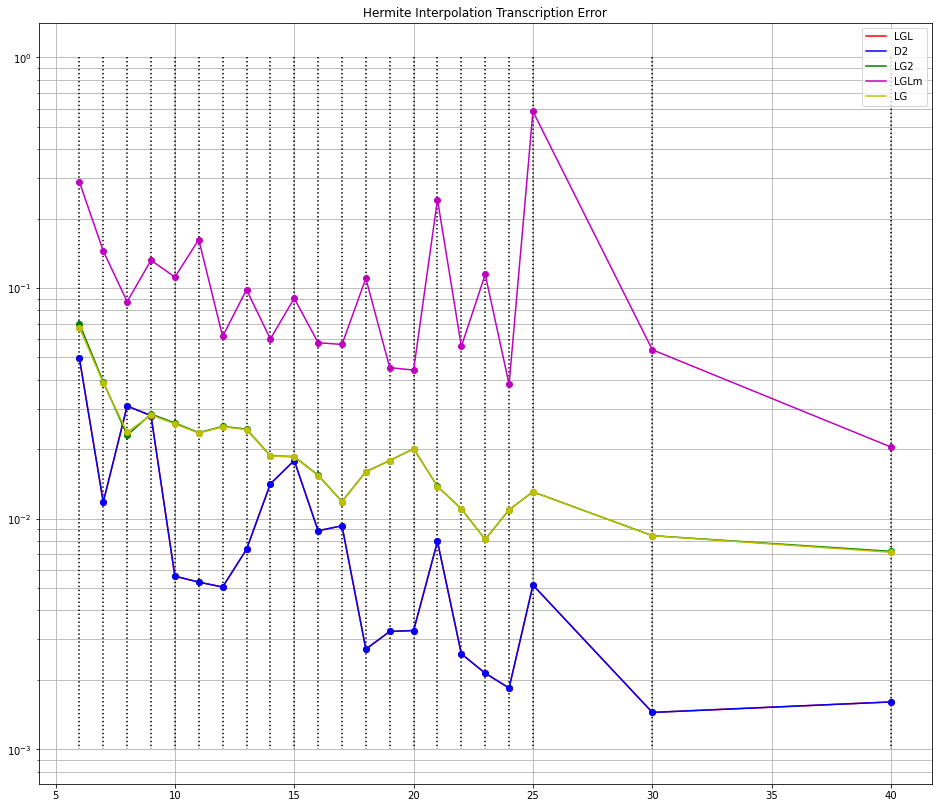

In [218]:
plt.figure(figsize=[16,14])

plt.title('Hermite Interpolation Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    lite = []
    test_N = results_pend[scheme]['N']
    for jj in range(len(test_N)):
        lite.append(error_transcr_pend_interp_hermite(
            results_pend[scheme]['q'][jj],
            results_pend[scheme]['v'][jj],
            results_pend[scheme]['u'][jj],
            0.,
            results_pend[scheme]['t_f'][jj],
            scheme))
    
    plt.plot(results_pend[scheme]['N'], lite, 'o' + color, alpha = 1)
    plt.plot(results_pend[scheme]['N'], lite, color, label = scheme, alpha = 1)
plt.grid(which='both')
plt.legend()
plt.yscale('log')
plt.vlines(results_pend['LGL']['N'], 1, 1e-3, 'k',':')

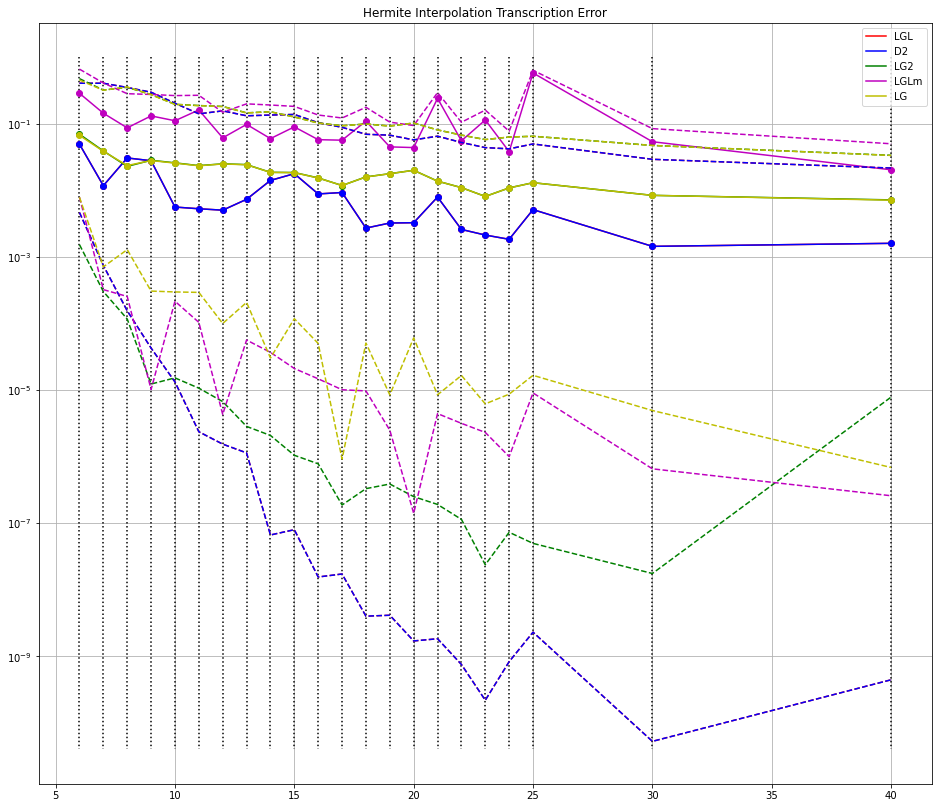

In [219]:
plt.figure(figsize=[16,14])

plt.title('Hermite Interpolation Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    lite = []
    test_N = results_pend[scheme]['N']
    for jj in range(len(test_N)):
        lite.append(error_transcr_pend_interp_hermite(
            results_pend[scheme]['q'][jj],
            results_pend[scheme]['v'][jj],
            results_pend[scheme]['u'][jj],
            0.,
            results_pend[scheme]['t_f'][jj],
            scheme))
    
    plt.plot(results_pend[scheme]['N'], lite, 'o' + color, alpha = 1)
    plt.plot(results_pend[scheme]['N'], lite, color, label = scheme, alpha = 1)
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    lite = []
    test_N = results_pend[scheme]['N']
    for jj in range(len(test_N)):
        lite.append(error_transcr_pend_interp(
            results_pend[scheme]['q'][jj],
            results_pend[scheme]['v'][jj],
            results_pend[scheme]['u'][jj],
            0.,
            results_pend[scheme]['t_f'][jj],
            scheme))
    
    plt.plot(results_pend[scheme]['N'], lite, '--' + color, alpha = 1)
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err'], color + '--', alpha = 1)
plt.grid(which='both')
plt.legend()
plt.yscale('log')
plt.vlines(results_pend['LGL']['N'], 1, 4e-11, 'k',':')

In [ ]:
@lru_cache
def error_transcr_pend_interp_hermite_u_smooth(qq, vv, uu, t0, t1, scheme = 'LGL'):
    N = len(qq)
    if scheme == 'LGL':
        tau = LGL(N)
    elif scheme == 'D2':
        tau = LGL(N)
    elif scheme == 'LG2':
        tau = LG2(N)
        uu = np.array([uu[0]] + list(uu) + [uu[-1]],dtype='float64')
    elif scheme == 'LG':
        tau = LG_1(N) + [1]
        uu = np.array([uu[0]] + list(uu) + [uu[-1]],dtype='float64')
        endp_f = LG_1_end_p_fun_cas(N, 20)
        qq_1 = float(endp_f(qq))
        vv_1 = float(endp_f(vv))
        qq = np.array(list(qq) + [qq_1,],dtype='float64')
        vv = np.array(list(vv) + [vv_1,],dtype='float64')
    elif scheme == 'LGLm':
        tau = LGL(N)
        uu = np.array([uu[0]] + list(uu) + [uu[-1]])
    
    
    coll_p = t_0 + (1 + np.array(tau,dtype='float64'))*(t1 - t0)/2
    t_arr = np.linspace(t0, t1, 1000)
    #print('uu: ', uu.dtype, uu.shape, uu)
    #print('qq shape:',qq.shape, 'coll points shape: ',coll_p.shape)
    qq_int = hermite(coll_p, qq, vv)(t_arr)
    vv_int = hermite(coll_p, vv, uu-np.sin(qq))(t_arr)
    uu_dot = np.gradient(uu, coll_p)
    uu_int = hermite(coll_p, uu, uu_dot)(t_arr)
    
    qq_dot_int = np.gradient(qq_int, t_arr)
    vv_dot_int = np.gradient(vv_int, t_arr)
    
    err_q_dot = (qq_dot_int - vv_int)**2
    err_v_dot = (vv_dot_int-(uu_int - np.sin(qq_int)))**2
    
    
    err_q = np.trapz(err_q_dot, t_arr)
    err_v = np.trapz(err_v_dot, t_arr)
    
    return err_q + err_v

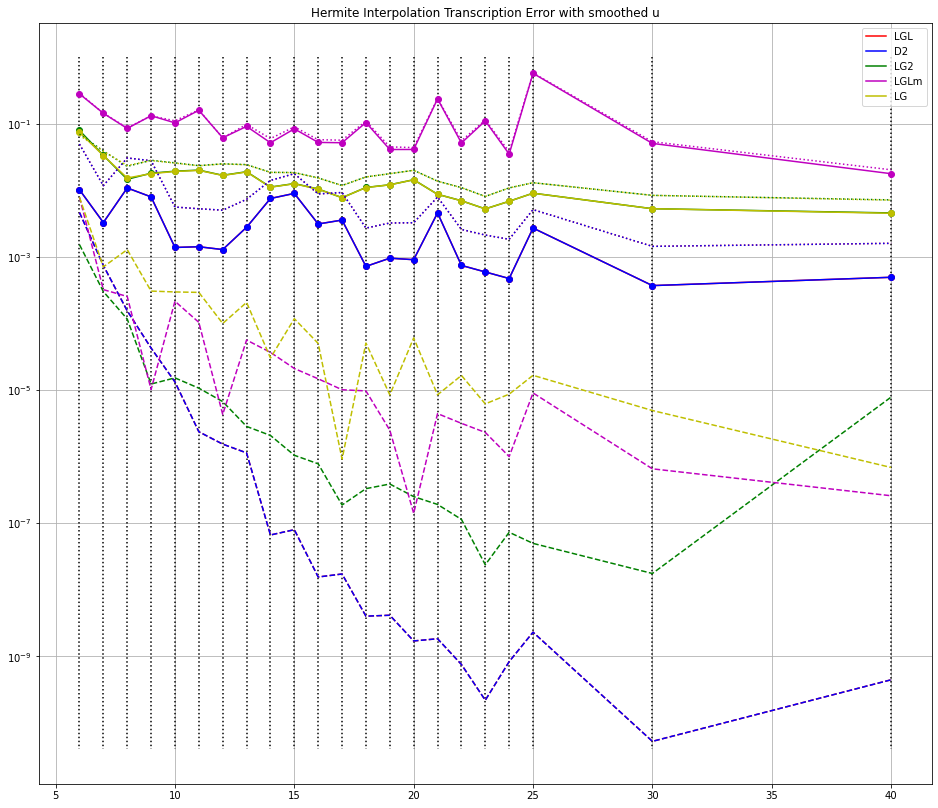

In [221]:
plt.figure(figsize=[16,14])

plt.title('Hermite Interpolation Transcription Error with smoothed u')
schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    lite = []
    test_N = results_pend[scheme]['N']
    for jj in range(len(test_N)):
        lite.append(error_transcr_pend_interp_hermite_u_smooth(
            results_pend[scheme]['q'][jj],
            results_pend[scheme]['v'][jj],
            results_pend[scheme]['u'][jj],
            0.,
            results_pend[scheme]['t_f'][jj],
            scheme))
    
    plt.plot(results_pend[scheme]['N'], lite, 'o' + color, alpha = 1)
    plt.plot(results_pend[scheme]['N'], lite, color, label = scheme, alpha = 1)
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    lite = []
    test_N = results_pend[scheme]['N']
    for jj in range(len(test_N)):
        lite.append(error_transcr_pend_interp_hermite(
            results_pend[scheme]['q'][jj],
            results_pend[scheme]['v'][jj],
            results_pend[scheme]['u'][jj],
            0.,
            results_pend[scheme]['t_f'][jj],
            scheme))
    
    plt.plot(results_pend[scheme]['N'], lite, ':' + color, alpha = 1)
for ii in range(5):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err'], color + '--', alpha = 1)
plt.grid(which='both')
plt.legend()
plt.yscale('log')
plt.vlines(results_pend['LGL']['N'], 1, 4e-11, 'k',':')

In [255]:
#@lru_cache
def error_transcr_pend_u_lin(qq, vv, uu, t0, t1, scheme = 'LGL'):
    N = len(qq)
    if scheme == 'LGL':
        tau = LGL(N)
    elif scheme == 'D2':
        tau = LGL(N)
    elif scheme == 'LG2':
        tau = LG2(N)
        uu = np.array([uu[0]] + list(uu) + [uu[-1]],dtype='float64')
    elif scheme == 'LG':
        tau = LG_1(N) + [1]
        uu = np.array([uu[0]] + list(uu) + [uu[-1]],dtype='float64')
        endp_f = LG_1_end_p_fun_cas(N, 20)
        qq_1 = float(endp_f(qq))
        vv_1 = float(endp_f(vv))
        qq = np.array(list(qq) + [qq_1,],dtype='float64')
        vv = np.array(list(vv) + [vv_1,],dtype='float64')
    elif scheme == 'LGLm':
        tau = LGL(N)
        uu = np.array([uu[0]] + list(uu) + [uu[-1]])
        
    coll_p = t_0 + (1 + np.array(tau,dtype='float64'))*(t1 - t0)/2
    t_arr = np.linspace(-1, 1, 1000)
    
    pol_q = lagrangePolynomial(tau, qq)
    pol_v = lagrangePolynomial(tau, vv)
    
    pol_q_dot = 2/(t1 - t0) * pol_q.diff(x)
    pol_v_dot = 2/(t1 - t0) * pol_v.diff(x)
    
    
    uu_int = np.interp(t_arr, tau, uu)
    
    
    
    vv_dot_int = np.array([pol_v_dot.evalf(n = 20, subs = {x:ii}) for ii in t_arr],dtype='float64')
    qq_int = np.array([pol_q.evalf(n = 20, subs = {x:ii}) for ii in t_arr],dtype='float64')
    err_v_dot = (vv_dot_int - (uu_int-np.sin(qq_int)))**2
    err_v = np.trapz(err_v_dot, t_arr)
    
    err_q_dot_pol = (pol_q_dot-pol_v)**2
    
    err_q_num = [err_q_dot_pol.evalf(n = 20, subs = {x:ii}) for ii in t_arr]
    err_q_num_int = np.trapz(np.array(err_q_num), t_arr)
    
    
    return (err_q_num_int + err_v) * (t1-t0)/2

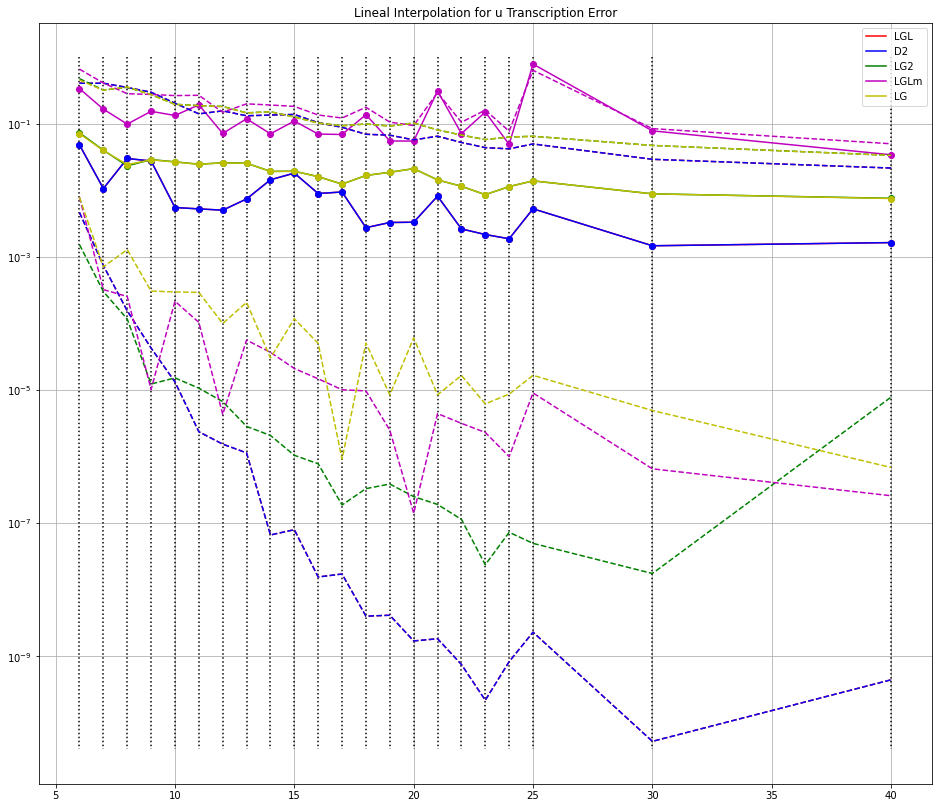

In [259]:
plt.figure(figsize=[16,14])

plt.title('Lineal Interpolation for u Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LGLm', 'LG']
colours = ['r', 'b', 'g', 'm', 'y']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_pend[scheme]['N']
    if not 'tr_err_u_lin' in results_pend[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr_pend_u_lin(
                results_pend[scheme]['q'][jj],
                results_pend[scheme]['v'][jj],
                results_pend[scheme]['u'][jj],
                0.,
                results_pend[scheme]['t_f'][jj],
                scheme))
        results_pend[scheme]['tr_err_u_lin'] = lite
    
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err_u_lin'], 'o' + color, alpha = 1)
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err_u_lin'], color, label = scheme, alpha = 1)
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_pend[scheme]['N']
    
    if not 'tr_err_lin' in results_pend[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr_pend_interp(
                results_pend[scheme]['q'][jj],
                results_pend[scheme]['v'][jj],
                results_pend[scheme]['u'][jj],
                0.,
                results_pend[scheme]['t_f'][jj],
                scheme))
        results_pend[scheme]['tr_err_lin'] = lite
    
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err_lin'], '--' + color, alpha = 1)
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err'], color + '--', alpha = 1)
plt.grid(which='both')
plt.legend()
plt.yscale('log')
plt.vlines(results_pend['LGL']['N'], 1, 4e-11, 'k',':')

In [281]:
def error_transcr_pend_q_lin(qq, vv, uu, t0, t1, scheme = 'LGL'):
    N = len(qq)
    if scheme == 'LGL':
        tau = LGL(N)
        pol_u = lagrangePolynomial(tau, uu)
    elif scheme == 'D2':
        tau = LGL(N)
        pol_u = lagrangePolynomial(tau, uu)
    elif scheme == 'LG2':
        tau = LG2(N)
        pol_u = lagrangePolynomial(LG(N-2, 30), uu)
        
    elif scheme == 'LG':
        tau = LG_1(N) + [1]
        pol_u = lagrangePolynomial(LG(N-1, 30), uu)
        endp_f = LG_1_end_p_fun_cas(N, 20)
        qq_1 = float(endp_f(qq))
        vv_1 = float(endp_f(vv))
        qq = np.array(list(qq) + [qq_1,],dtype='float64')
        vv = np.array(list(vv) + [vv_1,],dtype='float64')
    elif scheme == 'LGLm':
        tau = LGL(N)
        pol_u = lagrangePolynomial(LGLm(N-2, 30), uu)
        
    tau_arr = np.linspace(-1, 1, 1000)
    uu_int = np.array([pol_u.evalf(n = 20, subs = {x:ii}) for ii in tau_arr],dtype='float64')
    
    coll_p = t_0 + (1 + np.array(tau,dtype='float64'))*(t1 - t0)/2
    t_arr = np.linspace(t0, t1, 1000)
    
    qq_int = np.interp(t_arr, coll_p, qq)
    vv_int = np.interp(t_arr, coll_p, vv)

    
    qq_dot_int = find_der_polyline(t_arr, coll_p, qq)
    vv_dot_int = find_der_polyline(t_arr, coll_p, vv)
    
    err_q_dot = (qq_dot_int - vv_int)**2
    err_v_dot = (vv_dot_int-(uu_int - np.sin(qq_int)))**2
    
    
    err_q = np.trapz(err_q_dot, t_arr)
    err_v = np.trapz(err_v_dot, t_arr)
    
    return err_q + err_v


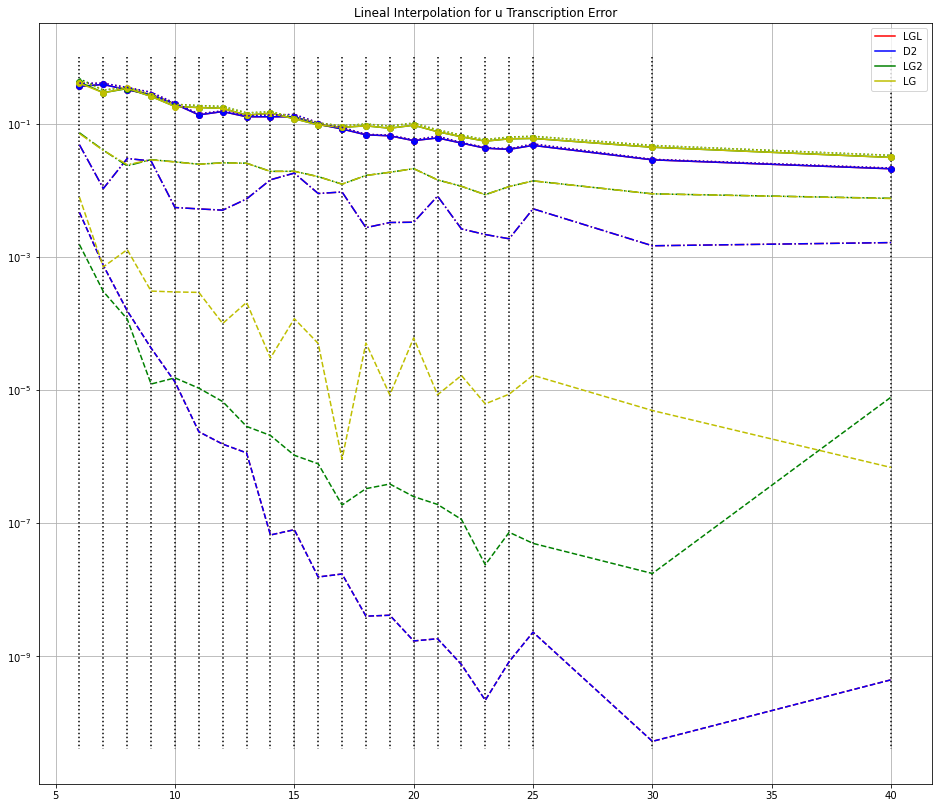

In [293]:
plt.figure(figsize=[16,14])

plt.title('Lineal Interpolation for u Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LG']#, 'LGLm'
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_pend[scheme]['N']
    if not 'tr_err_q_lin' in results_pend[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr_pend_q_lin(
                results_pend[scheme]['q'][jj],
                results_pend[scheme]['v'][jj],
                results_pend[scheme]['u'][jj],
                0.,
                results_pend[scheme]['t_f'][jj],
                scheme))
        results_pend[scheme]['tr_err_q_lin'] = lite
    
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err_q_lin'], 'o' + color, alpha = 1)
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err_q_lin'], color, label = scheme, alpha = 1)
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_pend[scheme]['N']
    if not 'tr_err_u_lin' in results_pend[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr_pend_u_lin(
                results_pend[scheme]['q'][jj],
                results_pend[scheme]['v'][jj],
                results_pend[scheme]['u'][jj],
                0.,
                results_pend[scheme]['t_f'][jj],
                scheme))
        results_pend[scheme]['tr_err_u_lin'] = lite
    
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err_u_lin'], '-.' + color, alpha = 1)
    
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_pend[scheme]['N']
    
    if not 'tr_err_lin' in results_pend[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr_pend_interp(
                results_pend[scheme]['q'][jj],
                results_pend[scheme]['v'][jj],
                results_pend[scheme]['u'][jj],
                0.,
                results_pend[scheme]['t_f'][jj],
                scheme))
        results_pend[scheme]['tr_err_lin'] = lite
    
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err_lin'], ':' + color, alpha = 1)
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err'], color + '--', alpha = 1)
plt.grid(which='both')
plt.legend()
plt.yscale('log')
plt.vlines(results_pend['LGL']['N'], 1, 4e-11, 'k',':')

### Pruebas para un cálculo de D más rápido

In [111]:
(legendre_poly(150, polys = True).real_roots()[1]- legendre_poly(150, polys = True).real_roots()[0]).evalf(20)

In [112]:
(legendre_poly(150, polys = True).real_roots()[1].evalf(20)- legendre_poly(150, polys = True).real_roots()[0].evalf(20))

In [113]:
@lru_cache
def _prod_term_gral(array, a, b, c, d):
    #if b>a:
    #    return -_prod_term_gral(array, b, a, c, d)
    #elif d>c:
    #    return -_prod_term_gral(array, a, b, d, c)
    #else:
        return(array[a]-array[b])/(array[c]-array[d])

@lru_cache
def _prod_term(array, i, j, l):
    return _prod_term_gral(array, l, j, i, j)

@lru_cache
def _producto(array, N, i, k, l):
    j_count = [jj for jj in range(N+1)]
    if i>k:
        j_count.pop(i)
        j_count.pop(k)
    else:
        j_count.pop(k)
        j_count.pop(i)
    #print(f'i: {i}, k: {k}, j_count: {j_count}')
    result = 1.
    for j in j_count:
        result = result * _prod_term(array, i, j, l)
    return result


@lru_cache
def sum_terms(array, N, i, l):
    k_count = [kk for kk in range(N+1)]
    k_count.pop(i)
    sum_total = 0
    for k in k_count:
        sum_total += 1/(array[i]-array[k])*_producto(array, N, i, k, l)
    return sum_total

#@lru_cache
def matrix_D_3(N, precission):
    taus = tuple(LGL(N+1, precission))
    M = zeros(N+1)
    for i in range(N+1):
        for l in range(N+1):
            M[l, i] = sum_terms(taus, N, i, l)
    return M

In [114]:
zeros(3)[1,2]

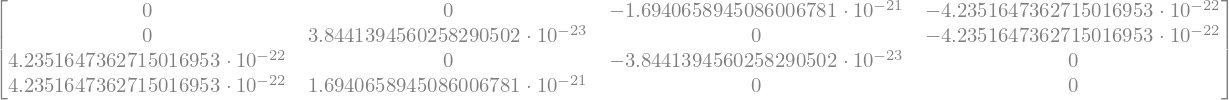

In [115]:
matrix_D_1(3, 20)- matrix_D_3(3, 20)

In [116]:
%%timeit

aa = matrix_D_3(20,20)

2.33 s ± 9.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [117]:
%%timeit

aa = matrix_D_3(20,20)

2.39 s ± 18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [118]:
%%timeit

aa = matrix_D_1(20,20)

61.6 ns ± 1.18 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [119]:
%%timeit

aa = matrix_D_2(20,20)

65 ns ± 1.17 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [120]:
sum_terms(tuple(LGL(3+1, 20)), 3, 0, 3)

In [121]:
phi_LGL(3+1, 0).diff().evalf(n = 20, subs = {x:LGL(3+1, 20)[3]})

In [225]:
@lru_cache
def matrix_D_1(N, precission):
    taus = LGL(N+1, precission)
    M = zeros(N+1)
    for i in range(N+1):
        func = phi_LGL(N+1, i).diff()
        for k in range(N+1):
            M[k, i] = func.evalf(n = precission, subs = {x:taus[k]})
    return M

In [224]:
@lru_cache
def matrix_D_2(N, precission):
    taus = LGL(N+1, precission)
    M = zeros(N+1)
    LN = legendre_poly(n = N, x=x)
    LN_t = [LN.evalf(n = precission, subs = {x:ii}) for ii in taus]
    for l in range(N+1):
        for k in range(N+1):
            if k != l :
                M[k,l] = LN_t[k]/(LN_t[l] * (taus[k]-taus[l]))
    M[0,0] = -N * (N+1)/4
    M[N,N] = N * (N+1)/4
    return M